In [1]:
import os
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import scipy
from scipy.signal import butter, lfilter
import matplotlib.colors as mcolors


%cd /media/Projects/Adrian/seizureProcessing/

from seizureProcessing.utils.loadNCS import *
from seizureProcessing.utils.get_chnames import *
from seizureProcessing.utils.readMatfile import *
from seizureProcessing.utils.loadNCS import *
from seizureProcessing.lfp.butter_lowpass_filter import *
from seizureProcessing.utils.loadNCS import *

/media/Projects/Adrian/seizureProcessing


# Spatio-temporal analysis of SD waves
The idea is to try to follow the SD wave as it travls through the bundle

In [2]:
def get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=0, stop_ms=2000, threshold_time_ms=1000, 
                            lpf_cutoff_fr_hz=3, filter_order=2, sf=1000):
    '''
    '''
    #initiate output array
    wave_delays = np.empty(len(data_in_reg))
    wave_delays.fill(np.nan)
    
    #calculate min and max of bundle
    #bundle_mean = np.mean([d[onset_adjust_ms:stop_ms]]
    minmax_data = np.asarray([abs(d[onset_adjust_ms:stop_ms]-np.mean(d[onset_adjust_ms:stop_ms])) 
                             for d in data_in_reg]).flatten()
    threshold = (max(minmax_data)-min(minmax_data))*0.5
    
    #iterate by wire
    for ix, wire in enumerate(data_in_reg):
        curr_data = wire[onset_adjust_ms:stop_ms] #cut data of interest
        filt = butter_lowpass_filter(curr_data, lpf_cutoff_fr_hz, sf, 
                                     order=filter_order)#filter data
        
        
        
        diff = np.diff(filt, n=1) #get first derivative of filtered data
        max_diff = abs(diff).argmax() + onset_adjust_ms #get abs maximum difference value 
        
        #make decision to add value
        amp_data = max(curr_data - np.mean(curr_data))-min(curr_data - np.mean(curr_data))*0.5
        #print(amp_data, threshold)
        if max_diff <= int(stop_ms/2):
            
            if amp_data >= threshold and (max(abs(curr_data))>250):
                wave_delays[ix] = max_diff
    
    return wave_delays

In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


In [4]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Patient 092, s02

In [5]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'
reref_path = find_dir(path, 'reref')
sd_regions = ['LAH', 'LMH']
onsets = [(30*60)+11, (31*60)+11]
regions = get_region_name(path)
_ = get_matfile_chnames(reref_path)
chnames, matfiles = _[0], _[1]
sf = 1000

#get matfiles grouped by region
matfiles_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items()}

sd_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items() if key in sd_regions}

all_regions = list(matfiles_dic.keys())
all_onsets = [(31*60)+11]*len(all_regions)

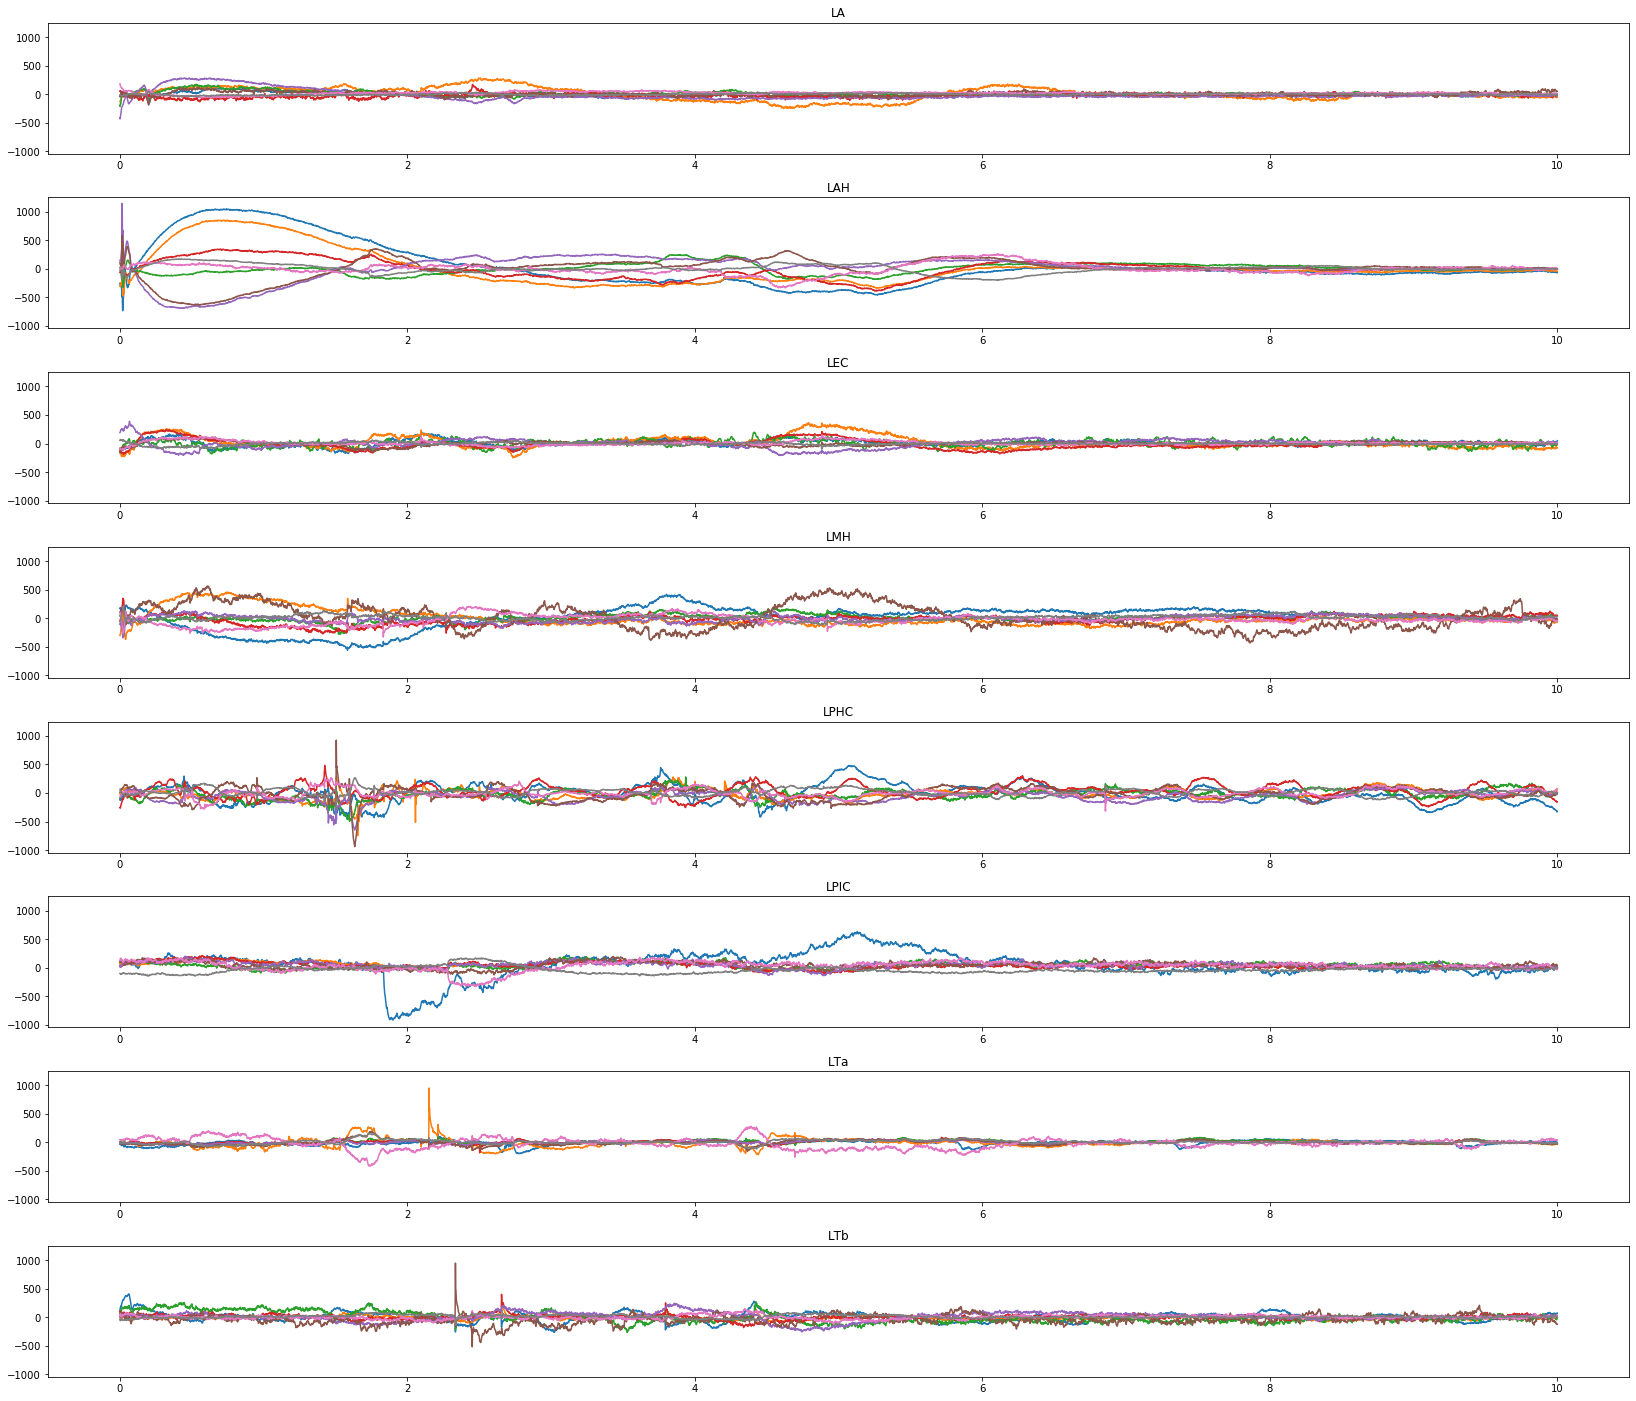

In [6]:
#plot all regions
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(31*60)+11]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf):(all_onsets[ix]*sf)+(10*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

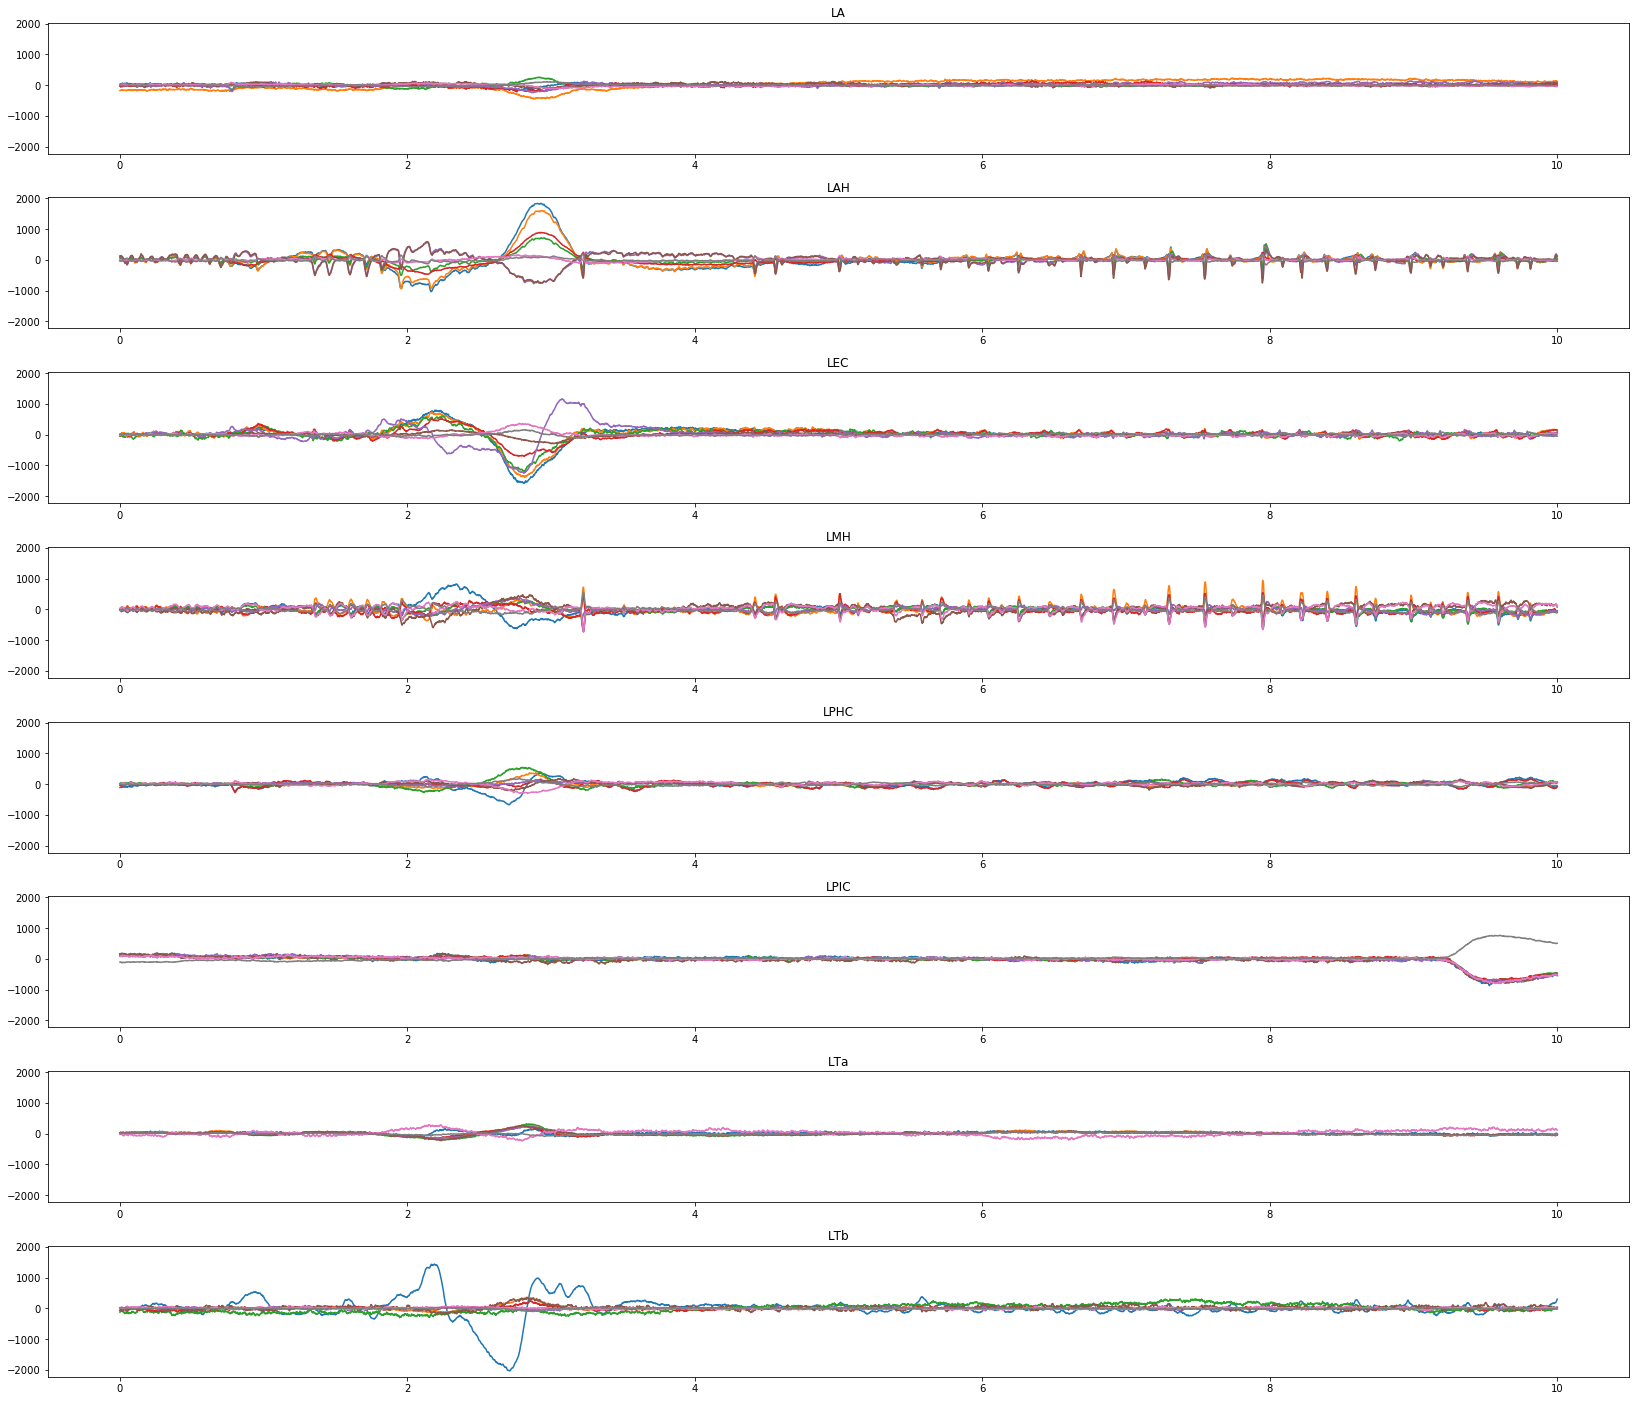

In [7]:
#plot all regions
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
all_onsets = [(30*60)]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf):(all_onsets[ix]*sf)+(10*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

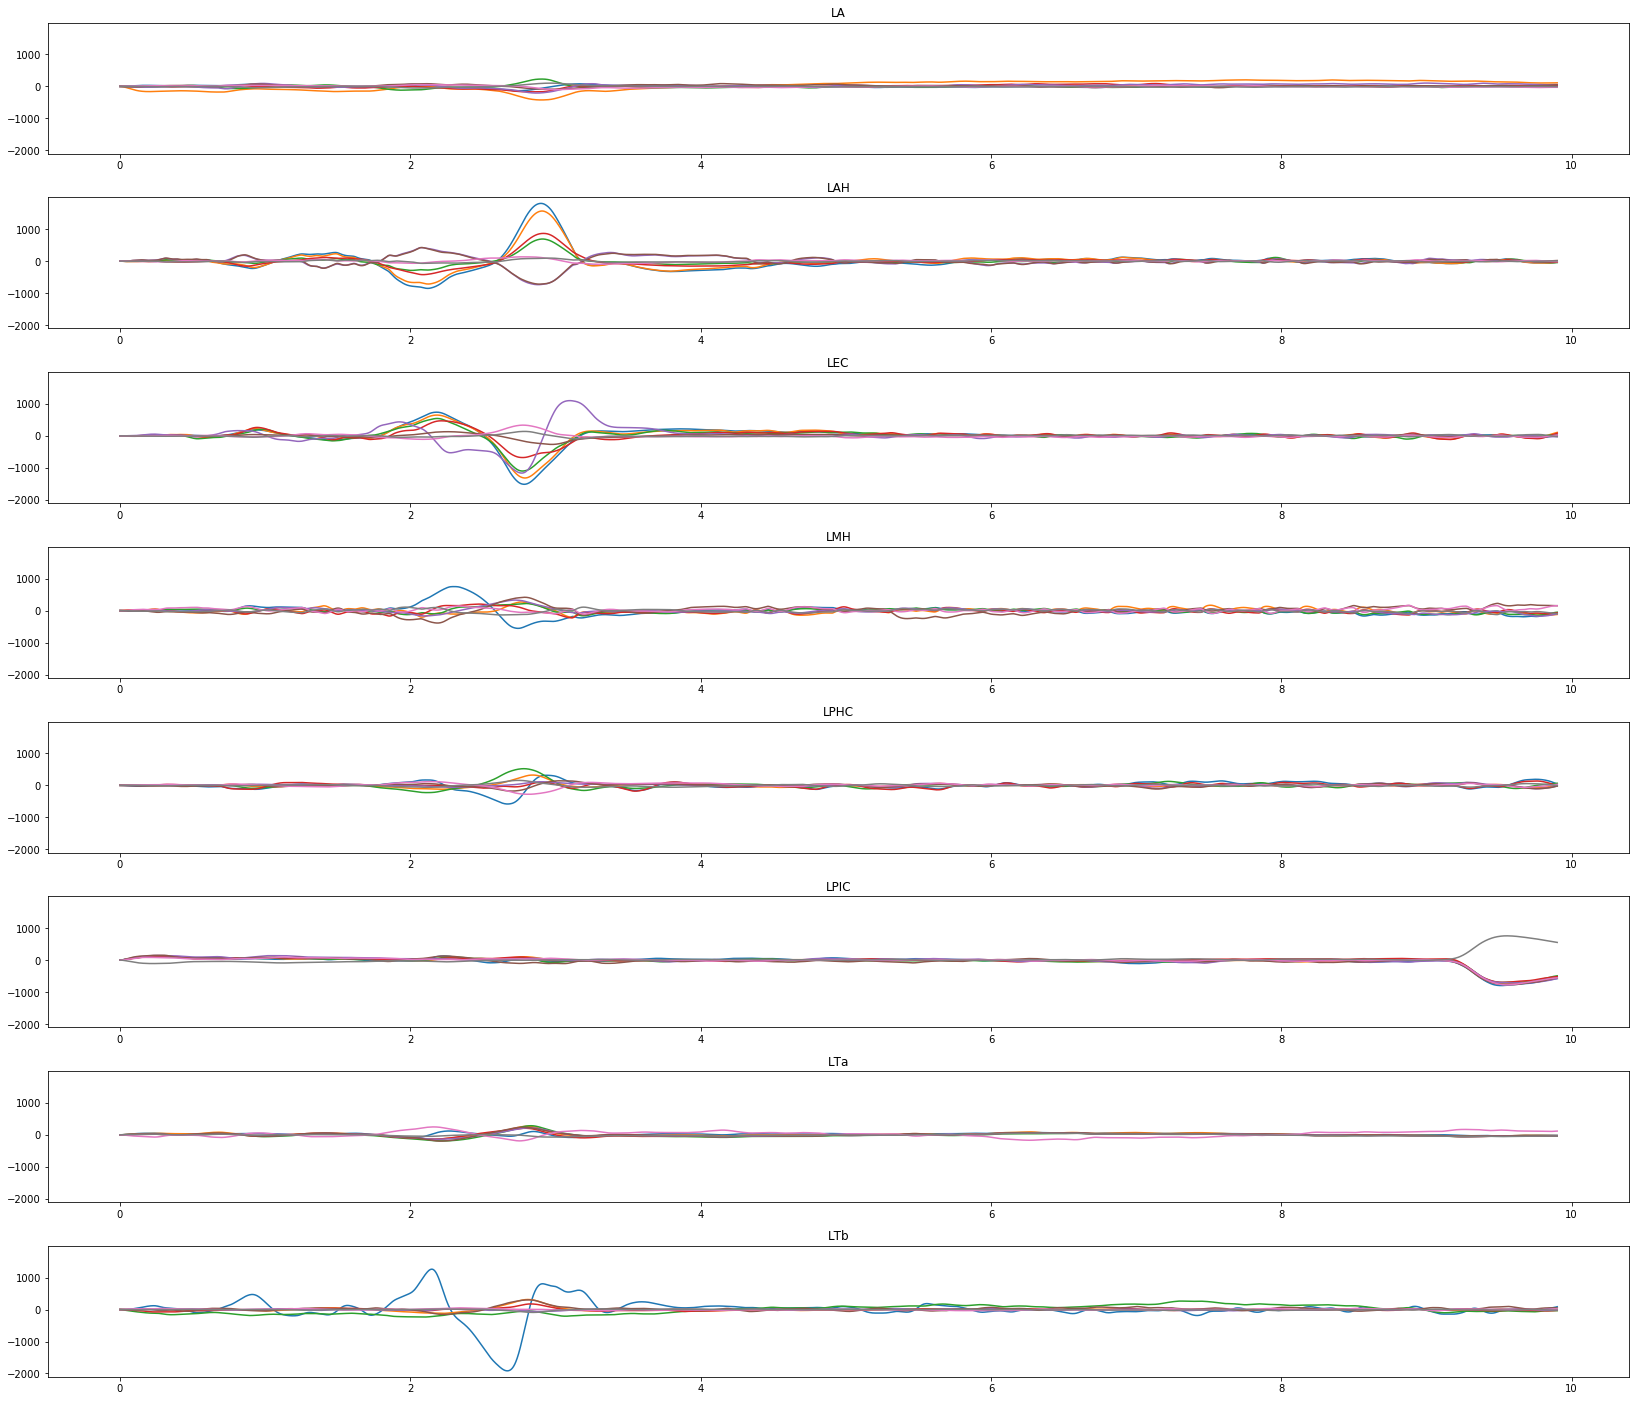

In [8]:
#plot all regions with a low-pass filter
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(30*60)+55]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf):(all_onsets[ix]*sf)+(10*sf)]
        data = data[100:]
        filt = butter_lowpass_filter(data, 3, 1000, order=2)
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), filt)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

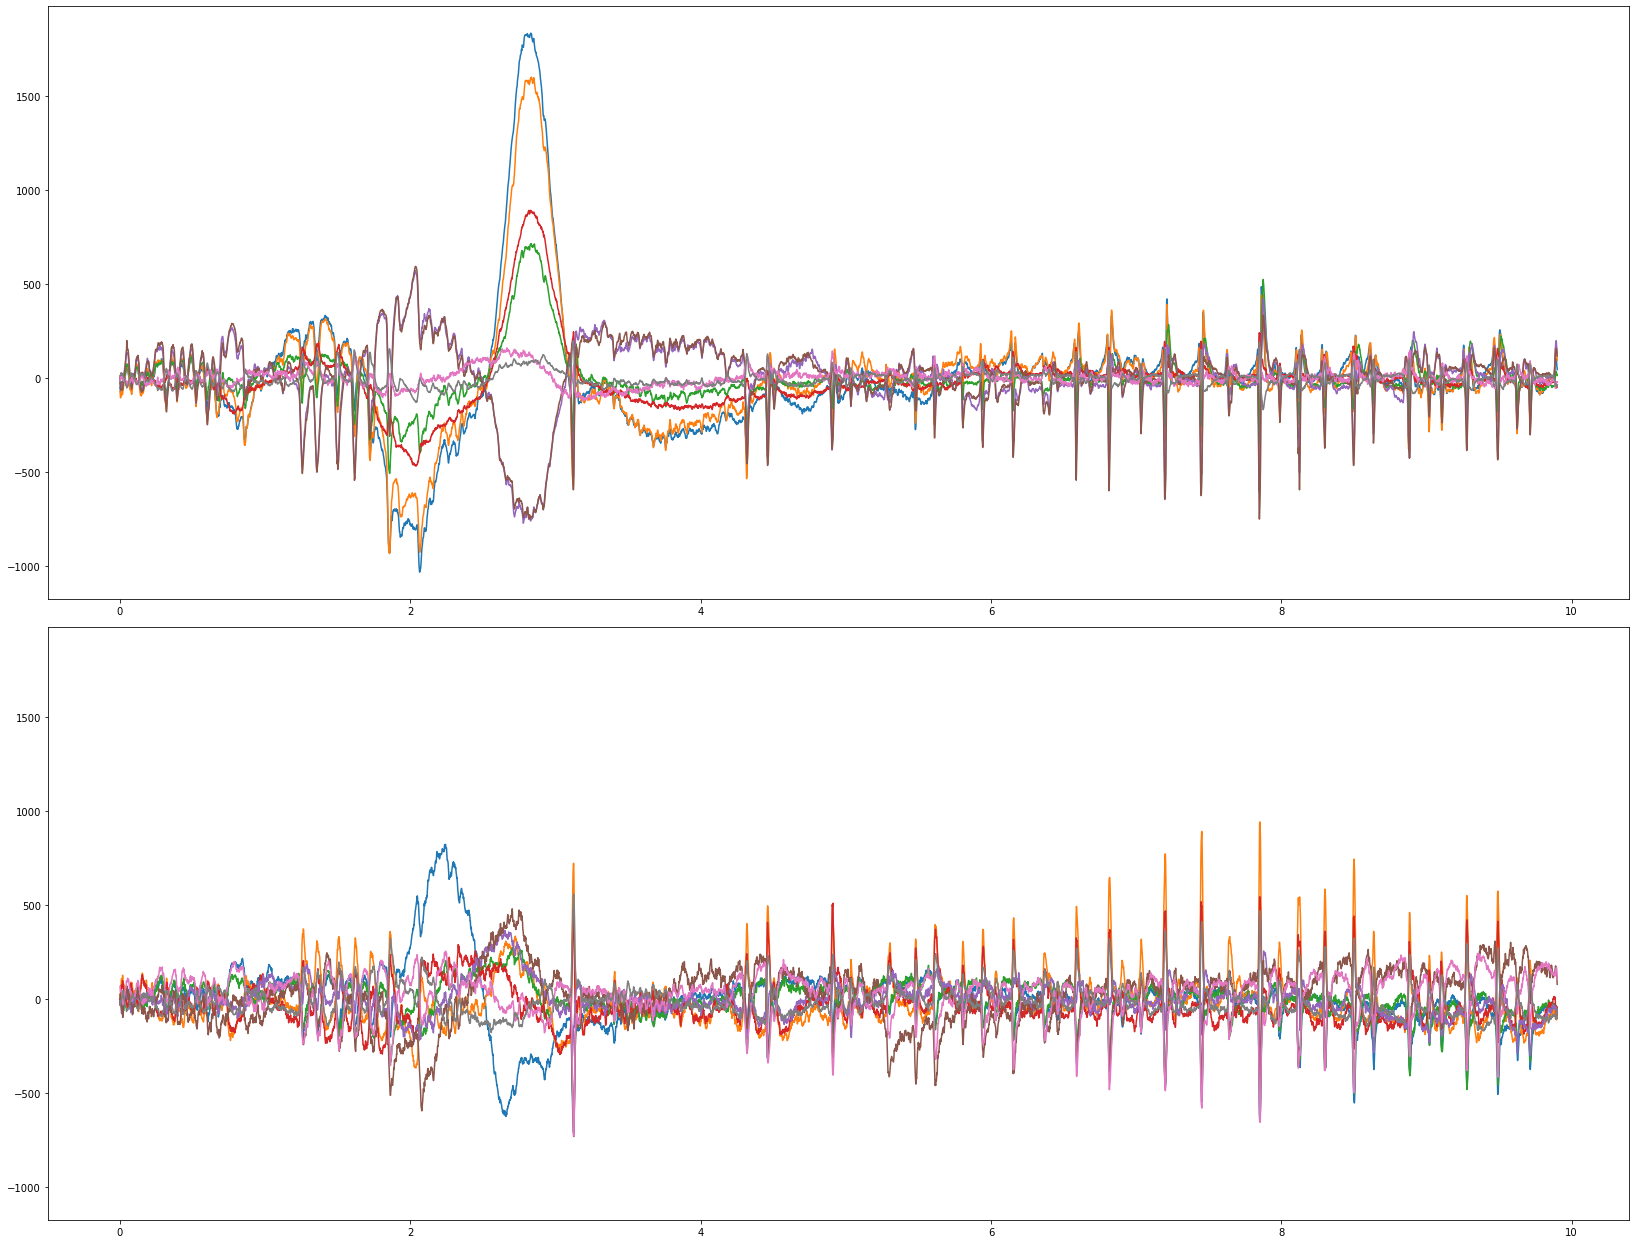

In [9]:
#plot the regions with SD
my_dpi = 92
fig, ax = plt.subplots(len(sd_regions), figsize =(2100/my_dpi, 1600/my_dpi), sharey=True)

for ix, reg in enumerate(sd_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf):(all_onsets[ix]*sf)+(10*sf)]
        data = data[100:]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
    
    
fig.tight_layout()
plt.show()

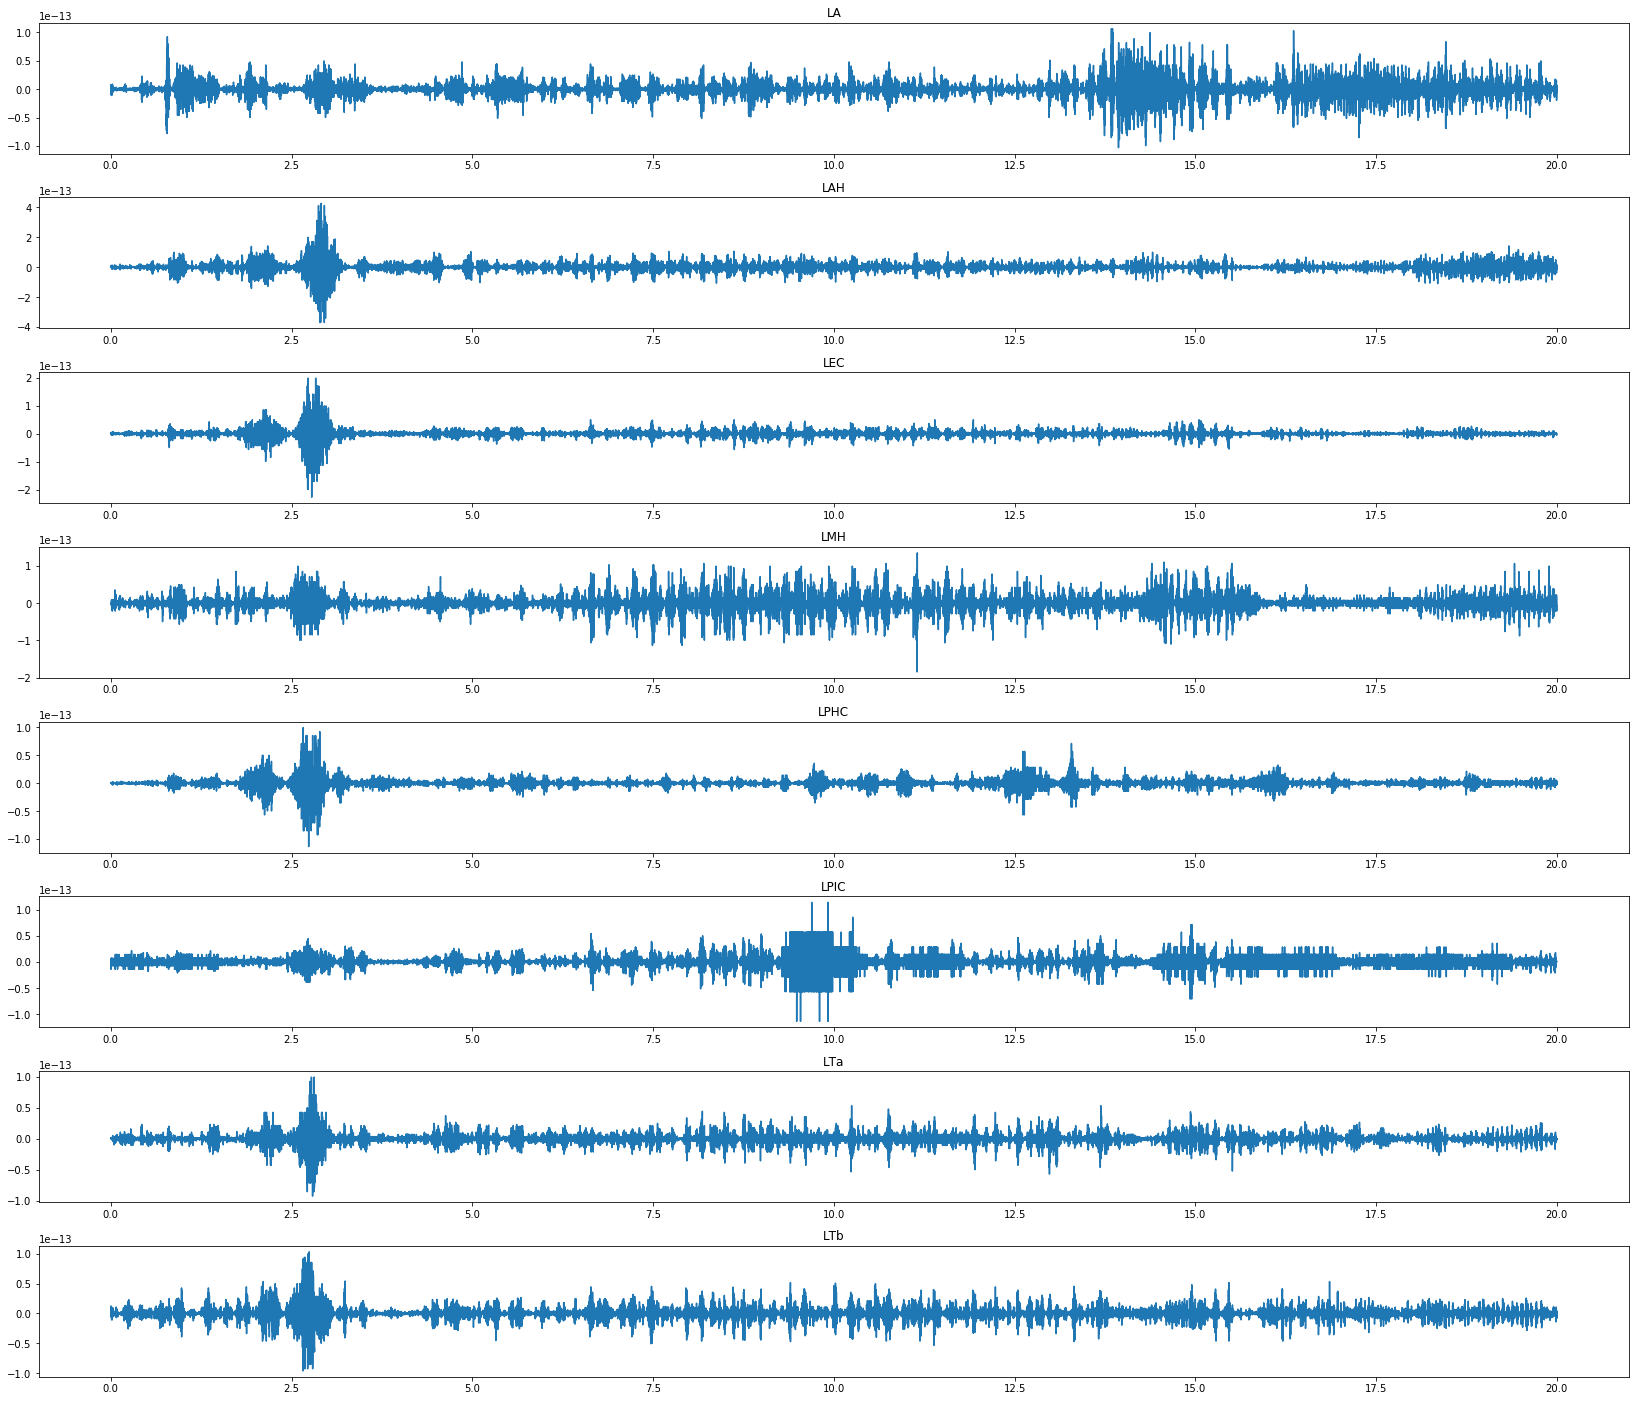

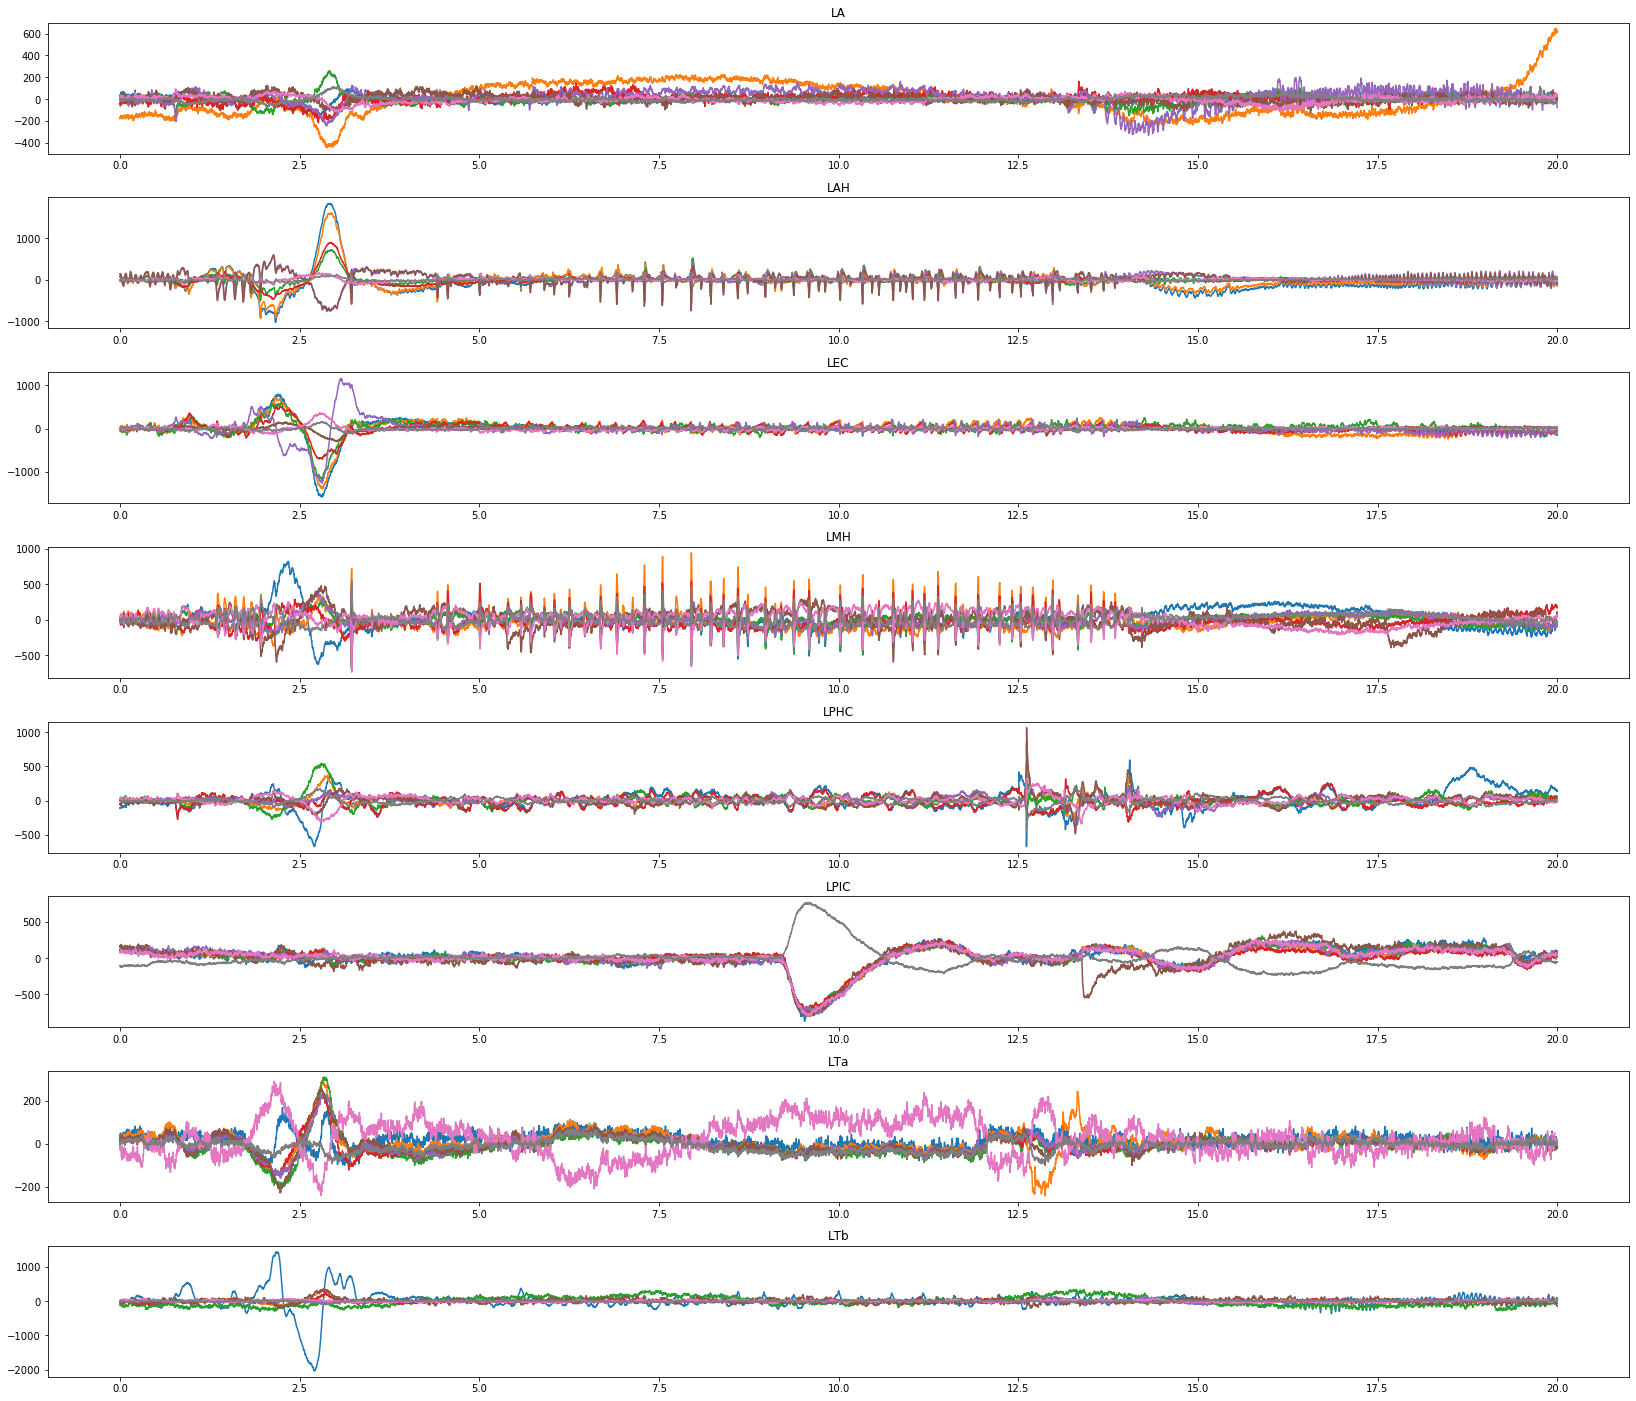

In [13]:
#plot seizure progression
my_dpi = 92
all_regions = list(matfiles_dic.keys())
seizure_onsets = [(30*60)]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    #data = []
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        if i == 0:
            data = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(20*sf)]
        else:
            data_ = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(20*sf)]
            #print(type(data))
            data = np.nanmean([data, data_], axis=0)
        #ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data, color='gray')
    ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    #data = []
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(20*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

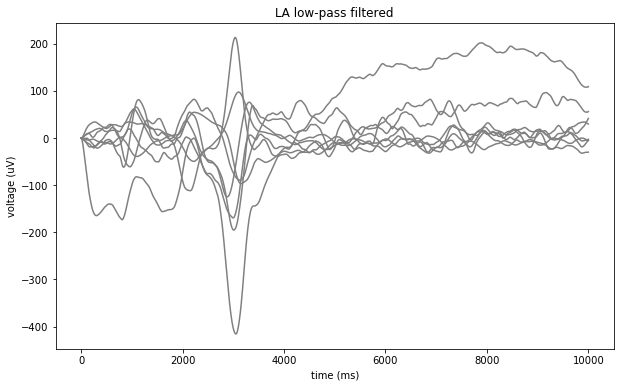

channels with SD: []
mean: nan ms


/tmp/ipykernel_34731/719996140.py:50: RuntimeWarning: Mean of empty slice
  print(f'mean: {np.nanmean(wave_delays[indices])} ms')


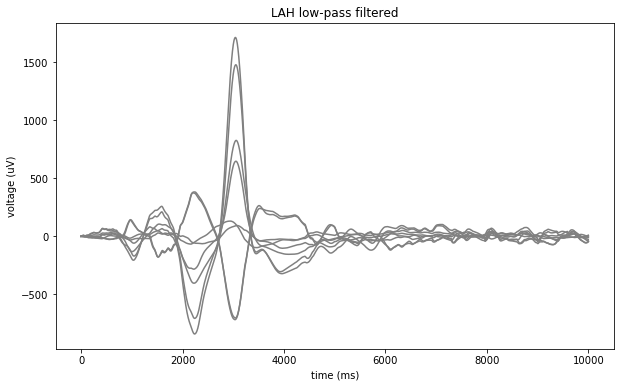

channels with SD: []
mean: nan ms


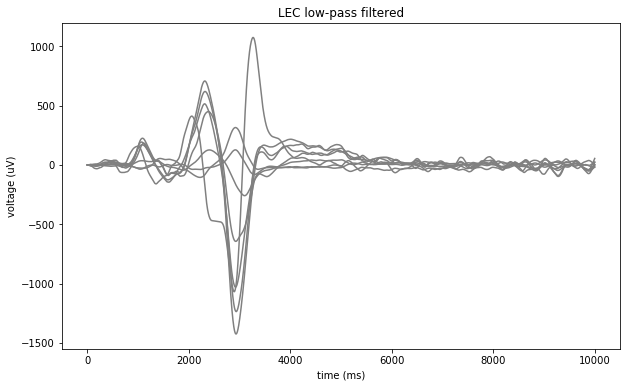

channels with SD: []
mean: nan ms


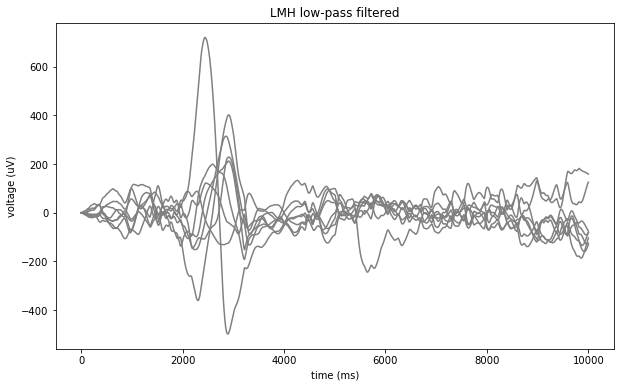

channels with SD: []
mean: nan ms


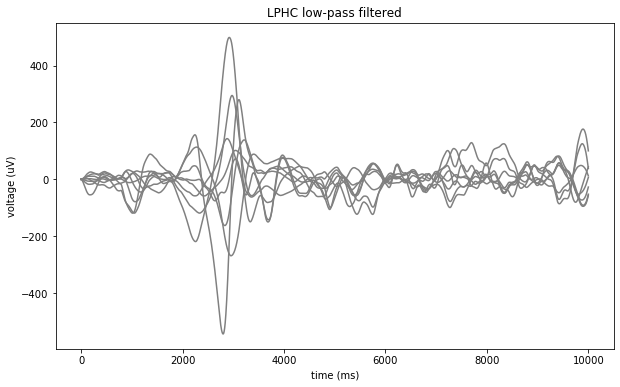

channels with SD: []
mean: nan ms


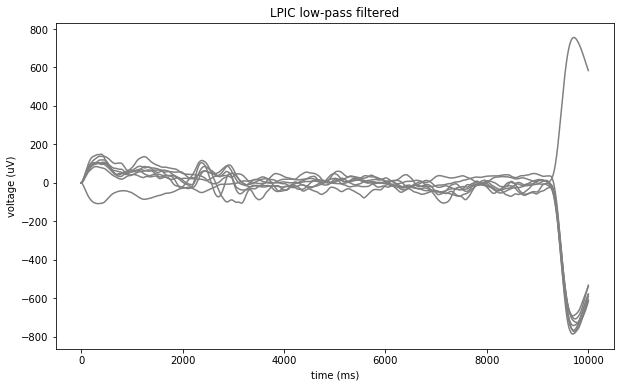

channels with SD: []
mean: nan ms


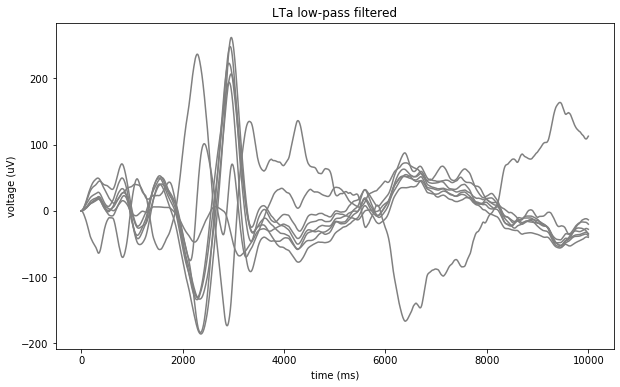

channels with SD: []
mean: nan ms


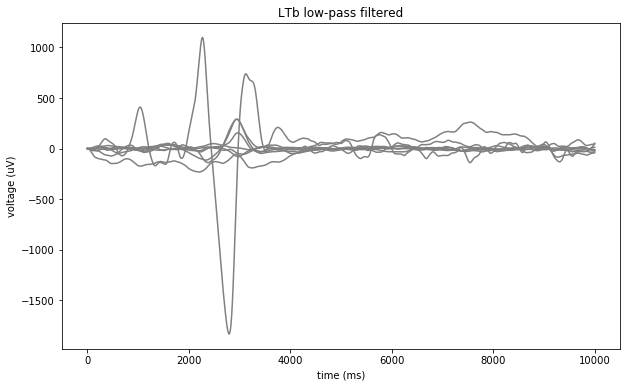

channels with SD: []
mean: nan ms


In [15]:
out_path = '/media/Seizures/Wenzel/temporospatial_analysis'
order=2
cutoff = 2
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    data_in_reg = []
    #get data
    for _, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data_in_reg.append(file.reref_data[(all_onsets[0]*sf):(all_onsets[0]*sf)+(10*sf)])
        
    #calculate delays
    wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=150, 
                                           filter_order=order, lpf_cutoff_fr_hz=cutoff)

    #sort indices
    indices = np.argsort(wave_delays)
    indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
    #print(indices)

    #plot results
    tabcols = list(mcolors.TABLEAU_COLORS.keys())
    plt.figure(figsize=(10,6))
    
    for i, ind in enumerate(data_in_reg):
        curr_data = ind
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:15000]
        plt.plot(curr_data, c='gray')
    
    
    for i, ind in enumerate(indices[:]):
        color = tabcols[i+1]

        curr_data = data_in_reg[ind]#[:2000]
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:15000]
        xdot = int(wave_delays[ind])
        plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
        plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')
        plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (uV)')
    
    plt.title(reg+ ' low-pass filtered')
    #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
    plt.show()
    
    print(f'channels with SD: {indices}')
    print(f'mean: {np.nanmean(wave_delays[indices])} ms')

In [8]:
out_path = '/media/Seizures/Wenzel/temporospatial_analysis'
order=2
cutoff = 2
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    data_in_reg = []
    #get data
    for _, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data_in_reg.append(file.reref_data[(all_onsets[0]*sf):(all_onsets[0]*sf)+(10*sf)])
        
    #calculate delays
    wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=150, 
                                           filter_order=order, lpf_cutoff_fr_hz=cutoff)

    #sort indices
    indices = np.argsort(wave_delays)
    indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
    #print(indices)

    #plot results
    tabcols = list(mcolors.TABLEAU_COLORS.keys())
    plt.figure(figsize=(10,6))
    
    for i, ind in enumerate(data_in_reg):
        curr_data = ind
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:2000]
        plt.plot(curr_data, c='gray')
    
    
    for i, ind in enumerate(indices[:]):
        color = tabcols[i+1]

        curr_data = data_in_reg[ind]#[:2000]
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:2000]
        xdot = int(wave_delays[ind])
        plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
        plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')
        plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (uV)')
    
    plt.title(reg+ ' low-pass filtered')
    #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
    plt.show()
    
    print(f'channels with SD: {indices}')
    print(f'mean: {np.nanmean(wave_delays[indices])} ms')

472.0

In [9]:
np.mean([288,310,333,385]) #lah

329.0

### Patient 074, s3

In [69]:
#load data
path = '/media/Seizures/60min_cut/074/2019-06-29_10-52-29/'
reref_path = find_dir(path, 'reref')
sd_regions = ['LAH', 'LMH']
onsets = [(30*60)+11, (31*60)+11]
regions = get_region_name(path)
_ = get_matfile_chnames(reref_path)
chnames, matfiles = _[0], _[1]
sf = 1000


#get matfiles grouped by region
matfiles_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items()}

sd_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items() if key in sd_regions}

all_regions = list(matfiles_dic.keys())
all_onsets = [(35*60)+31]*len(all_regions)

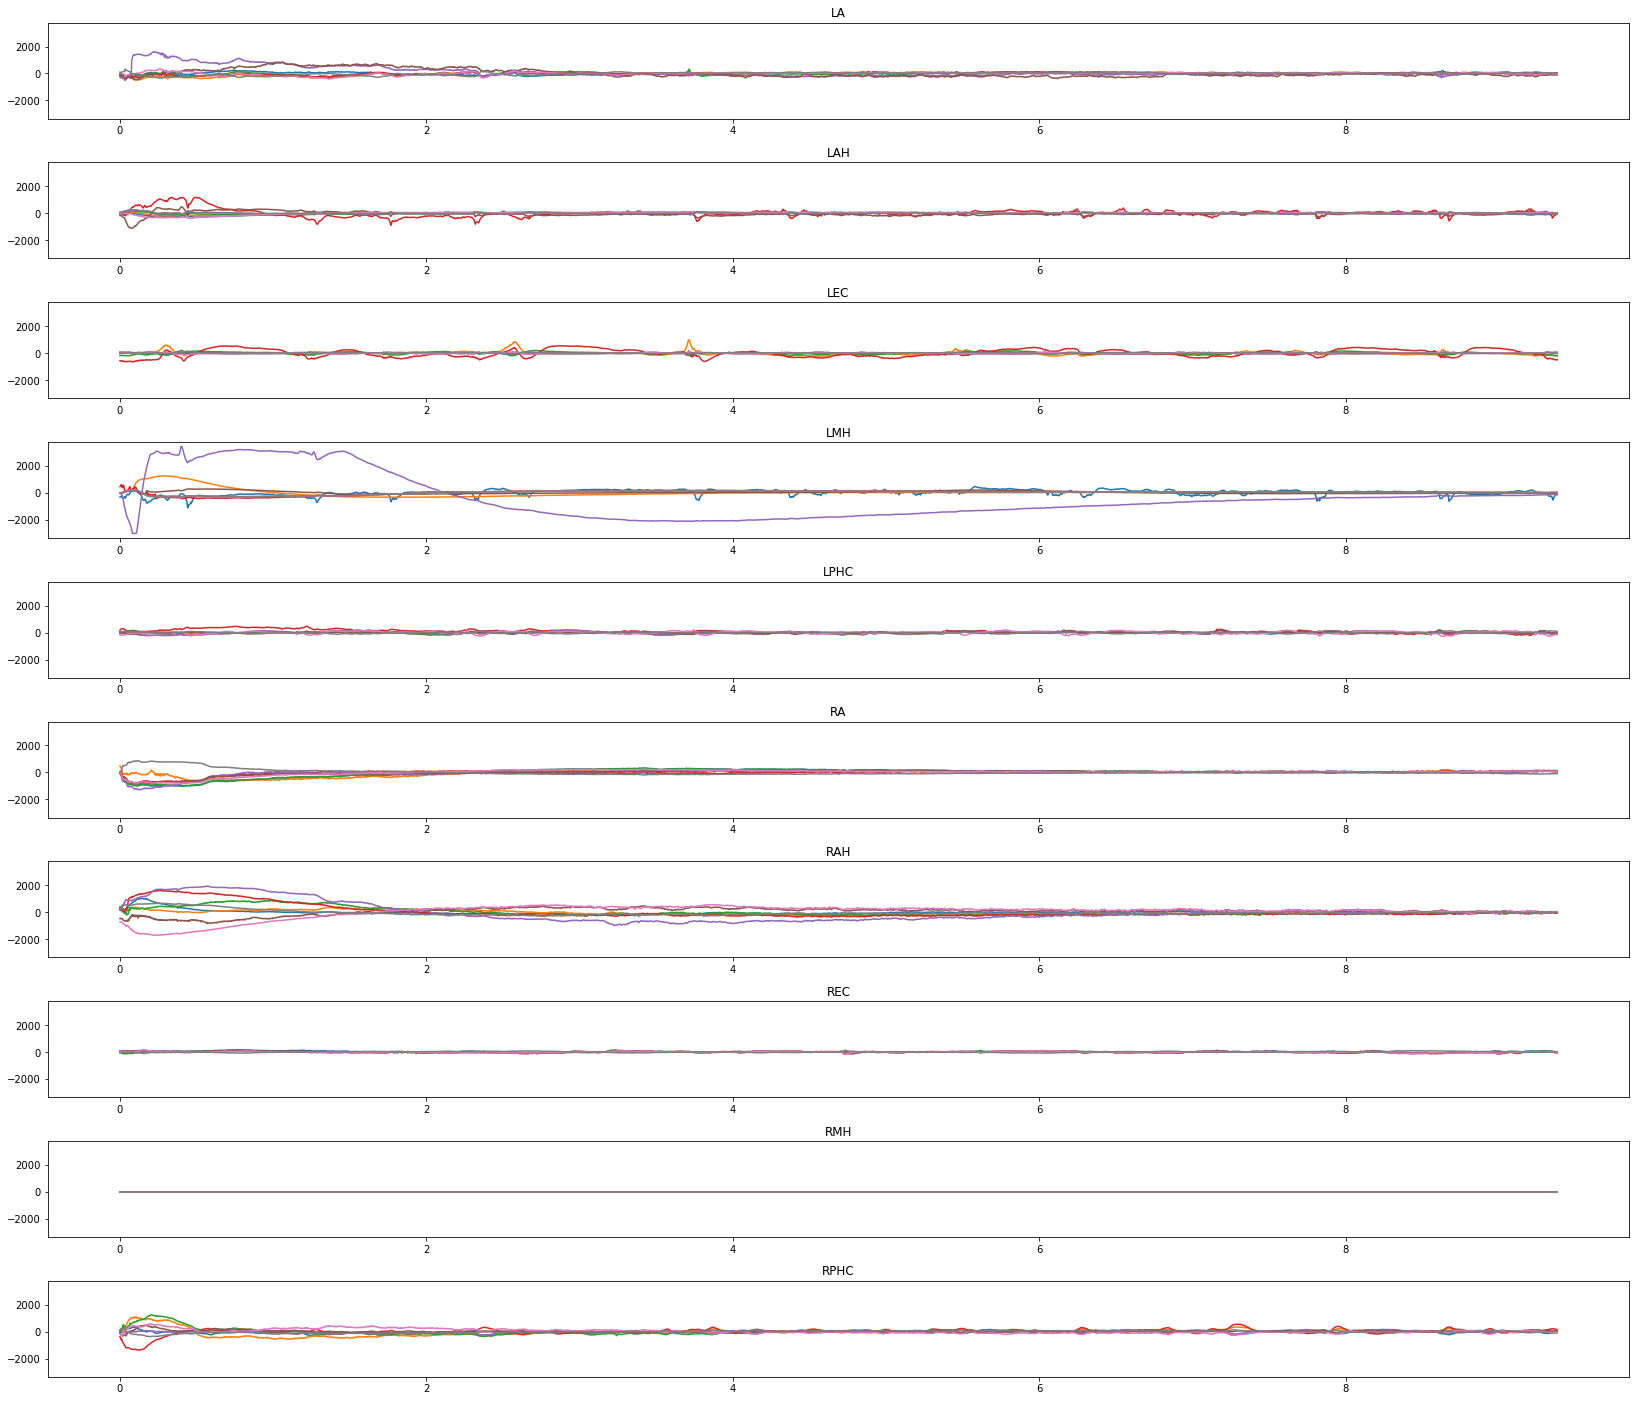

In [70]:
#plot all regions
my_dpi = 92
all_regions = list(matfiles_dic.keys())
all_onsets = [(35*60)+31]*len(all_regions)
extra_datapoints = 620

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf+extra_datapoints):(all_onsets[ix]*sf)+(10*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

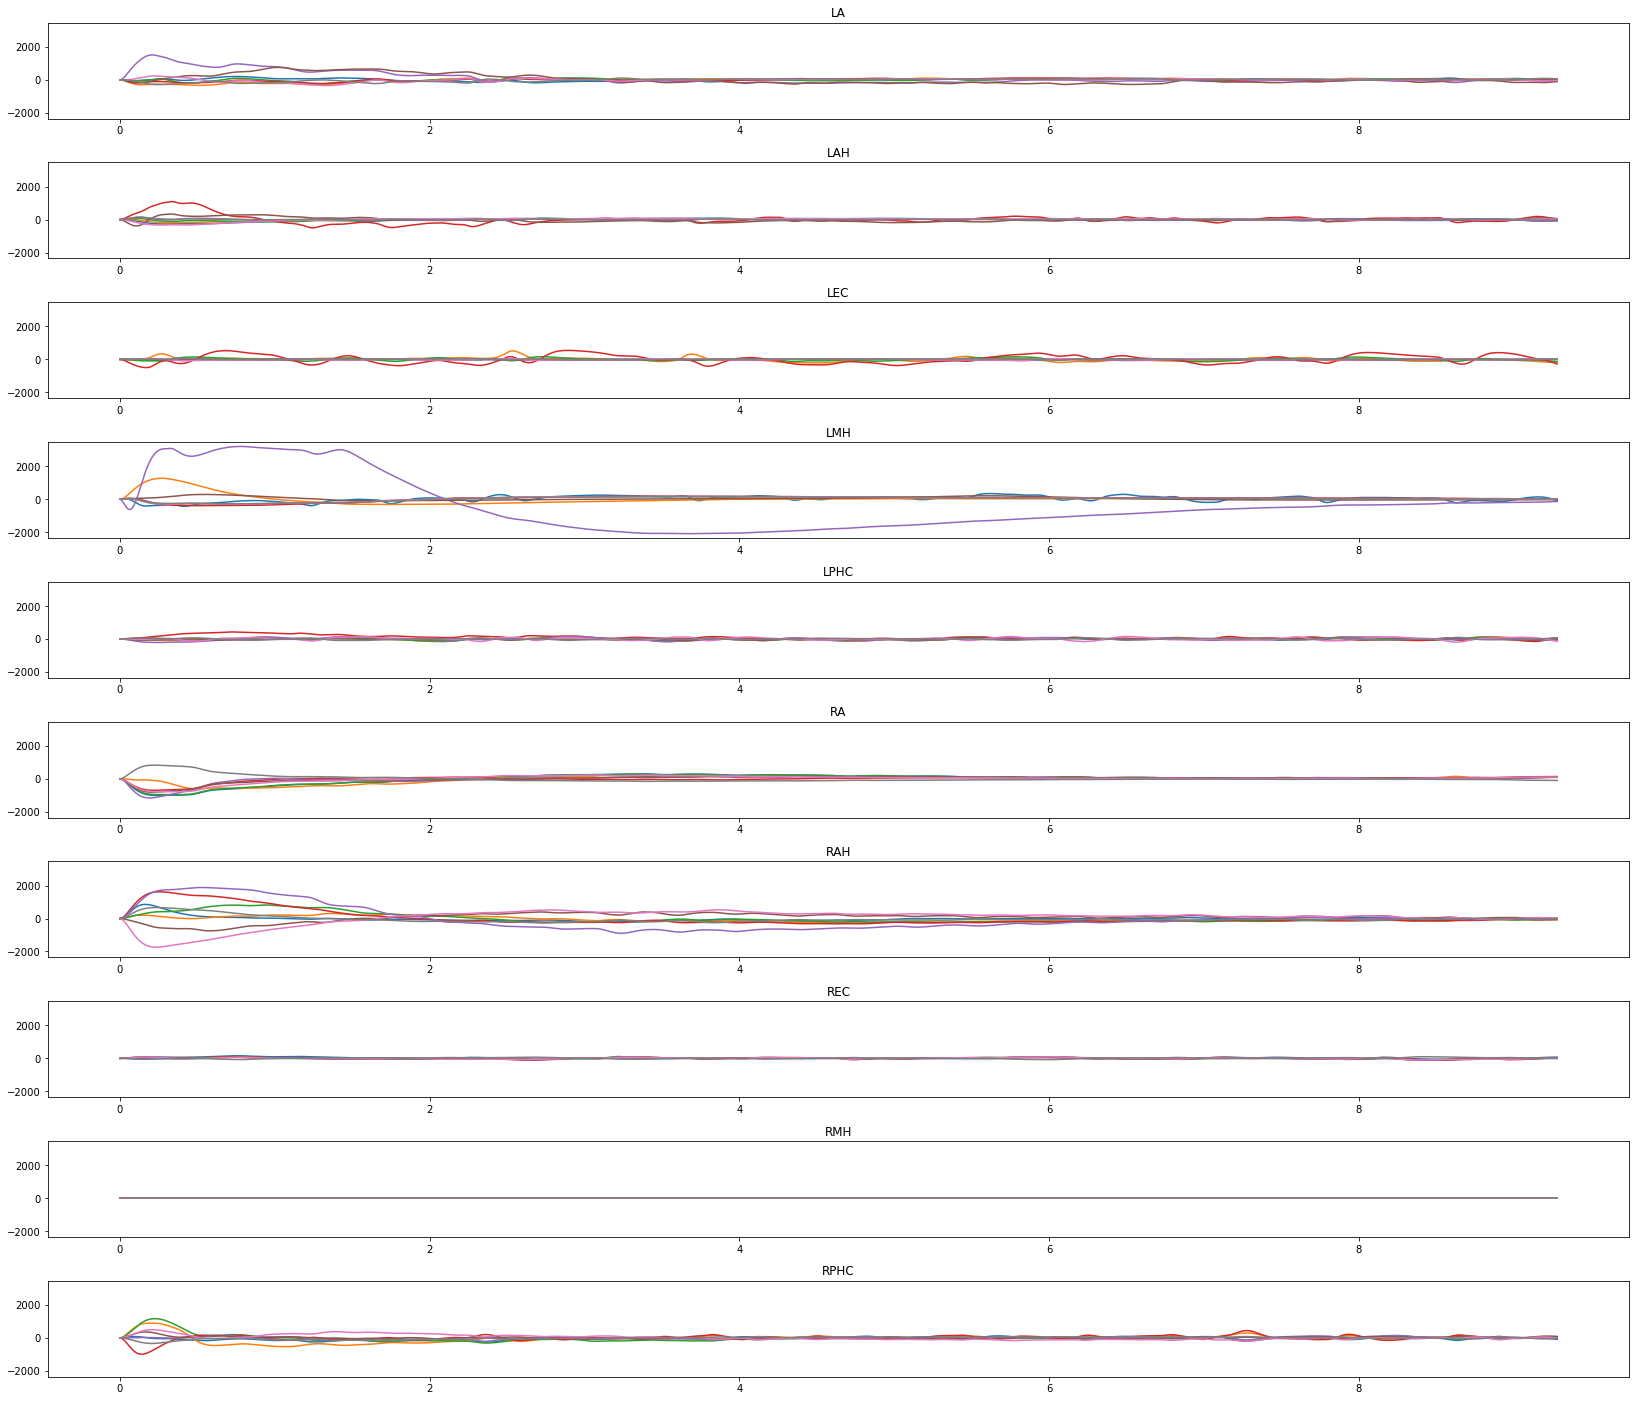

In [31]:
#plot all regions with a low-pass filter
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(30*60)+55]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf+extra_datapoints):(all_onsets[ix]*sf)+(10*sf)]
        data = data[100:]
        filt = butter_lowpass_filter(data, 3, 1000, order=2)
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), filt)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

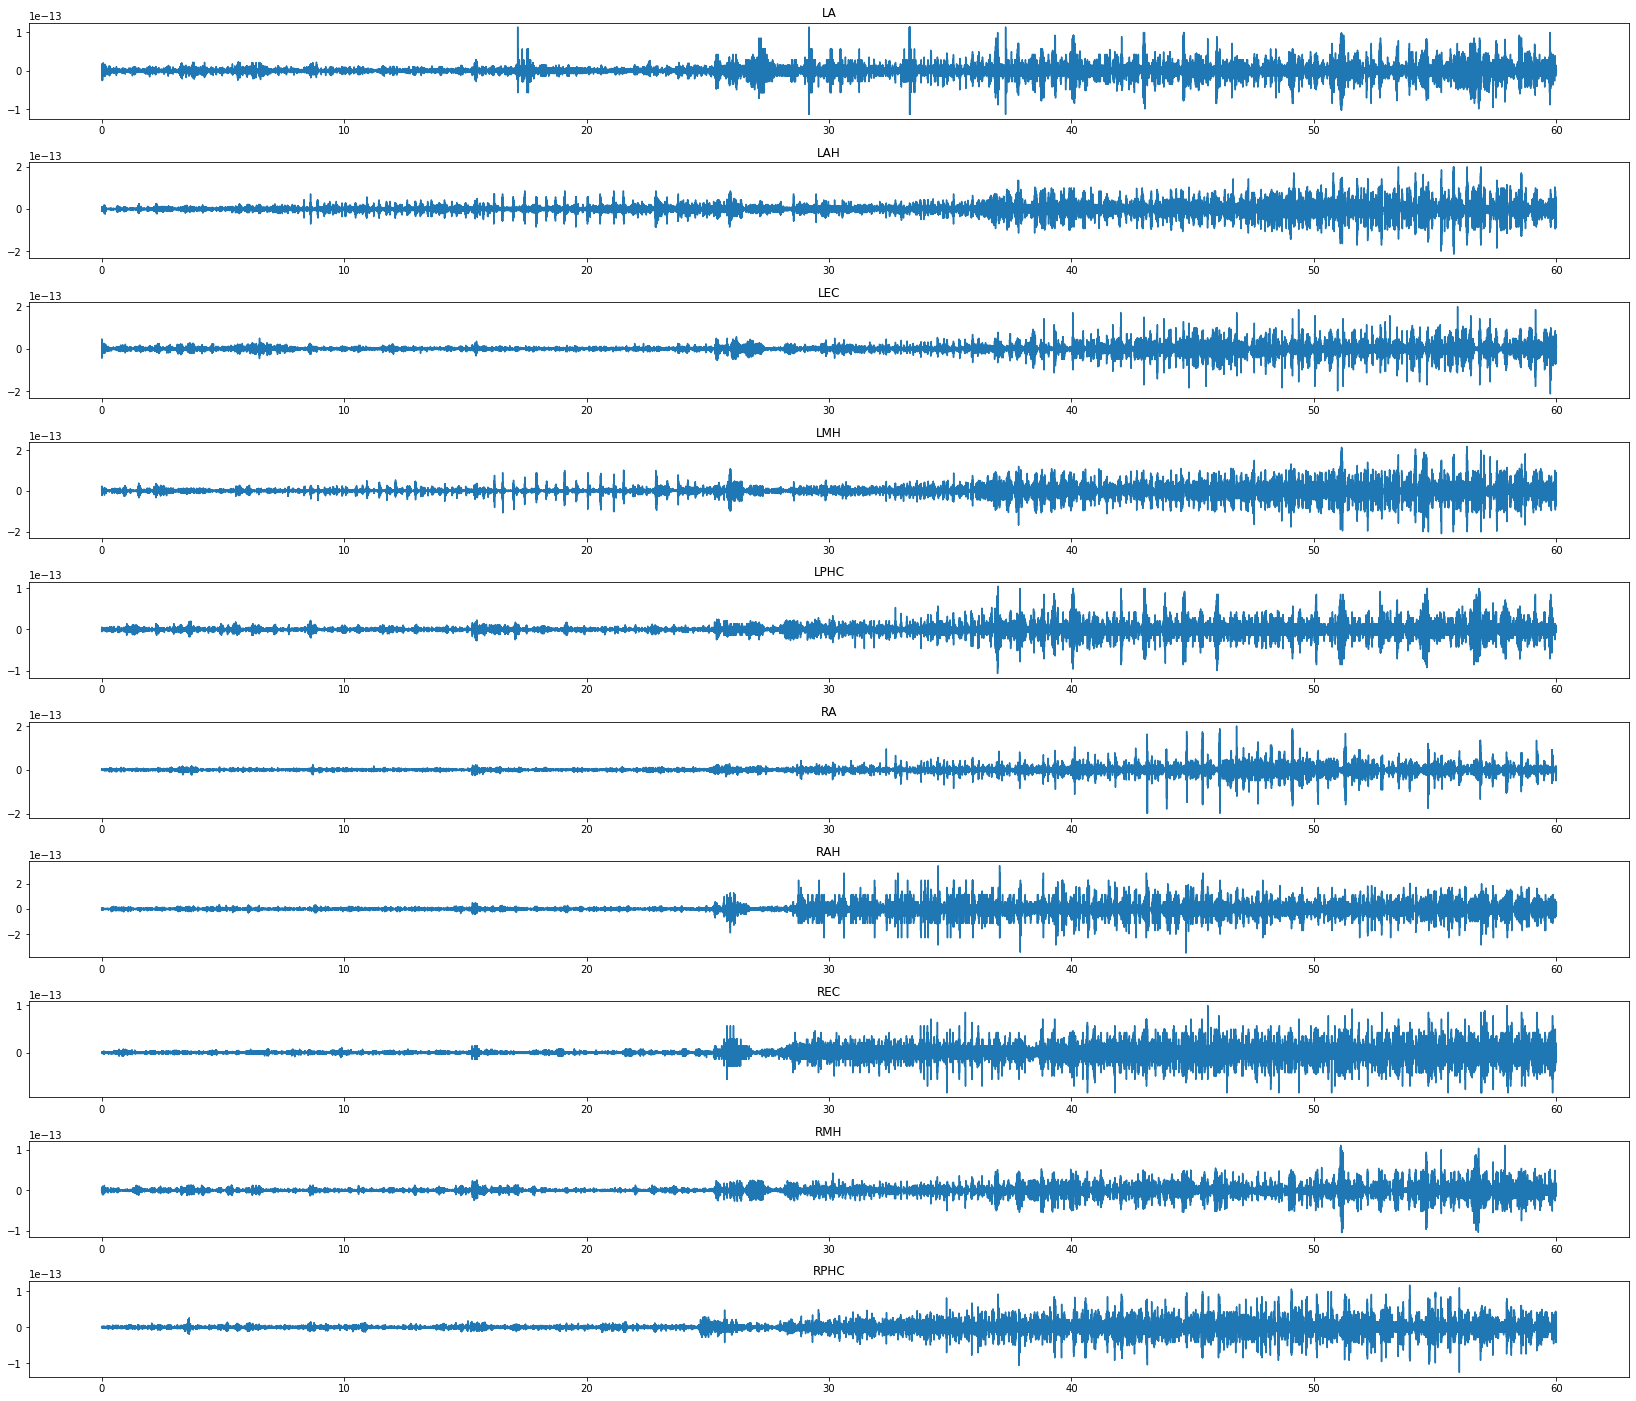

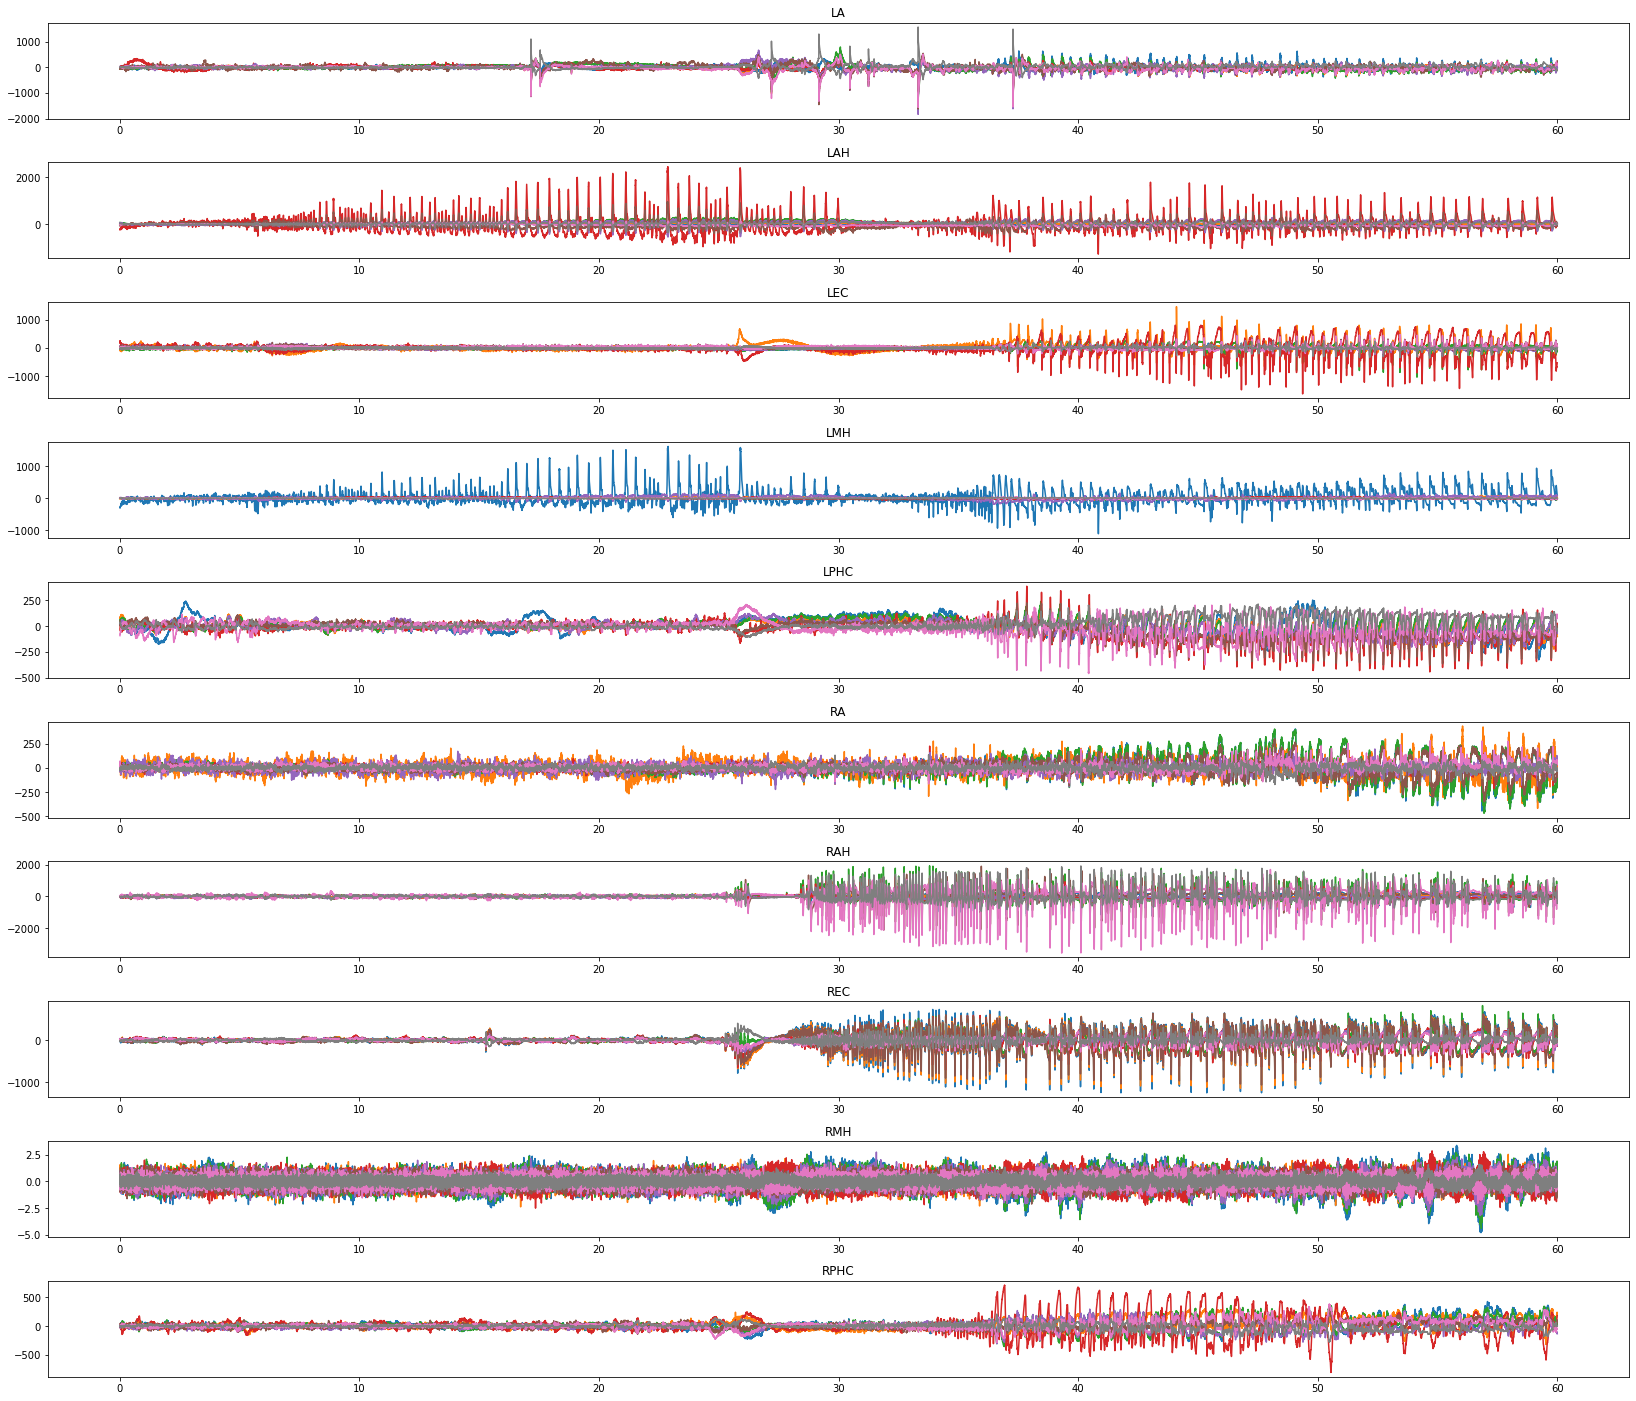

In [60]:
#plot seizure progression
my_dpi = 92
all_regions = list(matfiles_dic.keys())
seizure_onsets = [(30*60)]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    #data = []
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        if i == 0:
            data = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(60*sf)]
        else:
            data_ = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(60*sf)]
            #print(type(data))
            data = np.nanmean([data, data_], axis=0)
        #ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data, color='gray')
    ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    #data = []
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(60*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

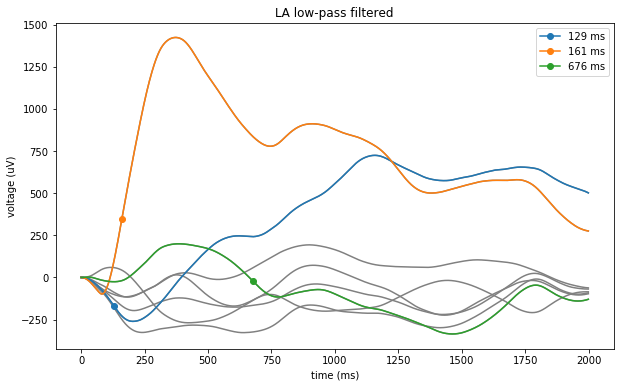

channels with SD: [5 4 6]
mean: 322.0 ms


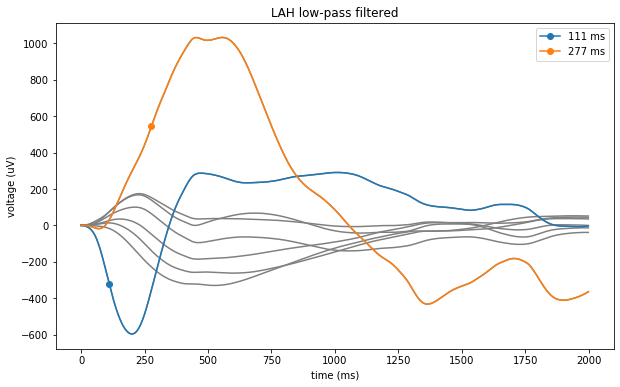

channels with SD: [5 3]
mean: 194.0 ms


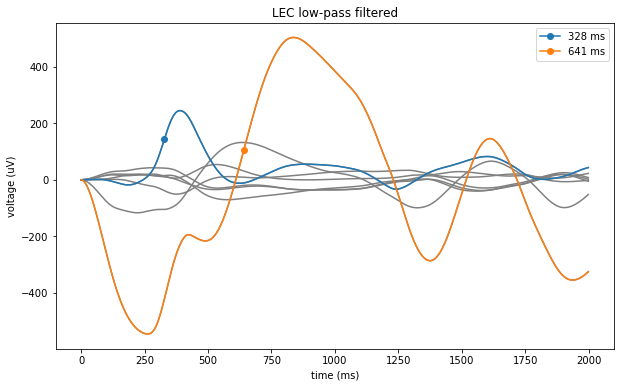

channels with SD: [1 3]
mean: 484.5 ms


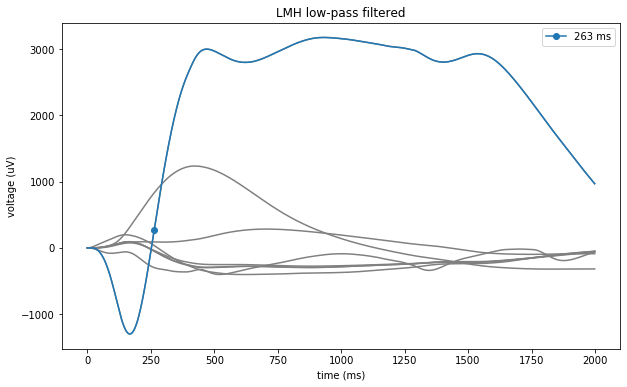

channels with SD: [4]
mean: 263.0 ms


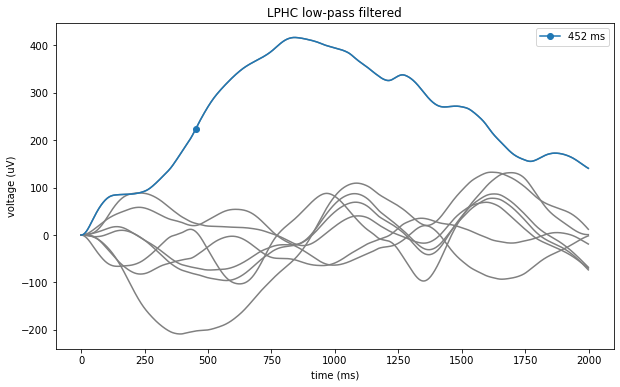

channels with SD: [3]
mean: 452.0 ms


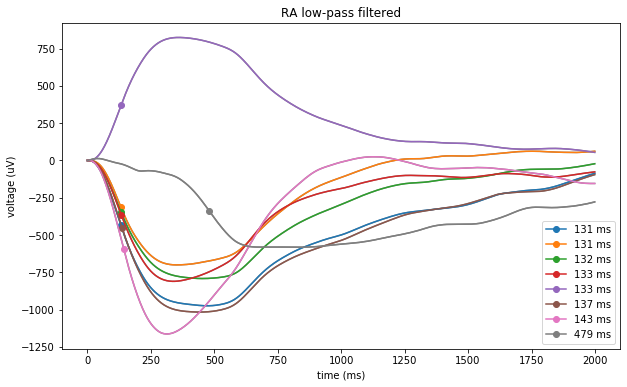

channels with SD: [2 3 6 5 7 0 4 1]
mean: 177.375 ms


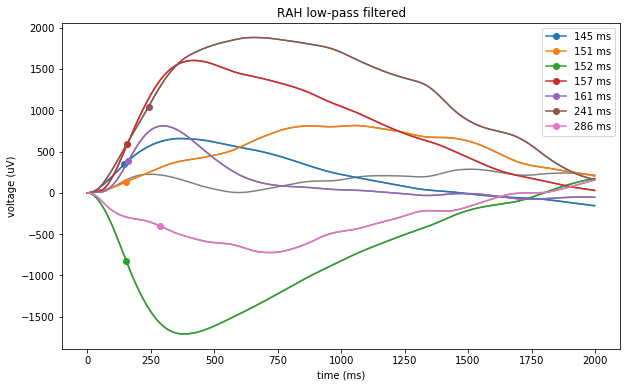

channels with SD: [7 2 6 3 0 4 5]
mean: 184.71428571428572 ms


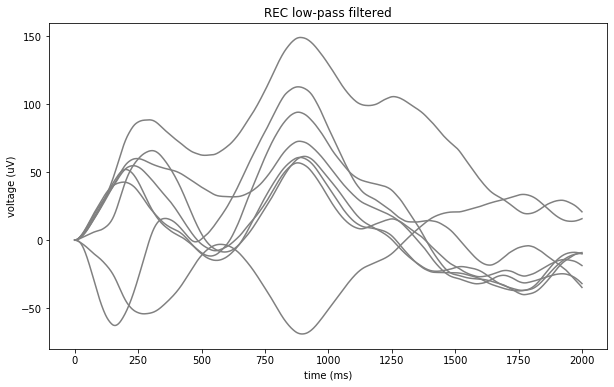

channels with SD: []
mean: nan ms


/tmp/ipykernel_79909/2740691452.py:50: RuntimeWarning: Mean of empty slice
  print(f'mean: {np.nanmean(wave_delays[indices])} ms')


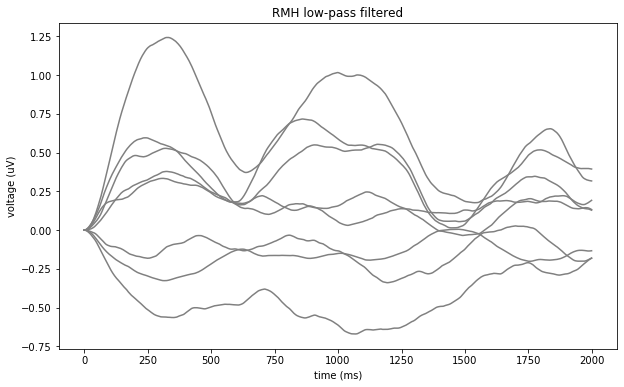

channels with SD: []
mean: nan ms


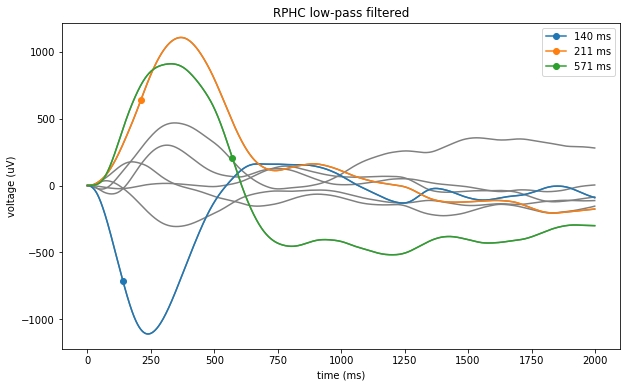

channels with SD: [3 2 1]
mean: 307.3333333333333 ms


In [71]:
out_path = '/media/Seizures/Wenzel/temporospatial_analysis'
order=2
cutoff = 2
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    data_in_reg = []
    #get data
    for _, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data_in_reg.append(file.reref_data[(all_onsets[0]*sf+extra_datapoints):(all_onsets[0]*sf)+(10*sf)])
        
    #calculate delays
    wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=50, 
                                           filter_order=order, lpf_cutoff_fr_hz=cutoff)

    #sort indices
    indices = np.argsort(wave_delays)
    indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
    

    #plot results
    tabcols = list(mcolors.TABLEAU_COLORS.keys())
    plt.figure(figsize=(10,6))
    
    for i, ind in enumerate(data_in_reg):
        curr_data = ind
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:2000]
        plt.plot(curr_data, c='gray')
    
    
    for i, ind in enumerate(indices[:]):
        color = tabcols[i+1]

        curr_data = data_in_reg[ind]#[:2000]
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:2000]
        xdot = int(wave_delays[ind])
        plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
        plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')
        plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (uV)')
    
    plt.title(reg+ ' low-pass filtered')
    #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
    plt.show()
    
    print(f'channels with SD: {indices}')
    print(f'mean: {np.nanmean(wave_delays[indices])} ms')

### patient 74, s.04

### Patient 089, s.1

In [93]:
path = '/media/Seizures/60min_cut/089/2021-04-19_03-43-56/'
reref_path = find_dir(path, 'reref')
sd_regions = ['LAH', 'LMH']
onsets = [(30*60)+11, (31*60)+11]
regions = get_region_name(path)
_ = get_matfile_chnames(reref_path)
chnames, matfiles = _[0], _[1]
sf = 1000

#get matfiles grouped by region
matfiles_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items()}

sd_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items() if key in sd_regions}

all_regions = list(matfiles_dic.keys())
all_onsets = [(30*60)+55]*len(all_regions)

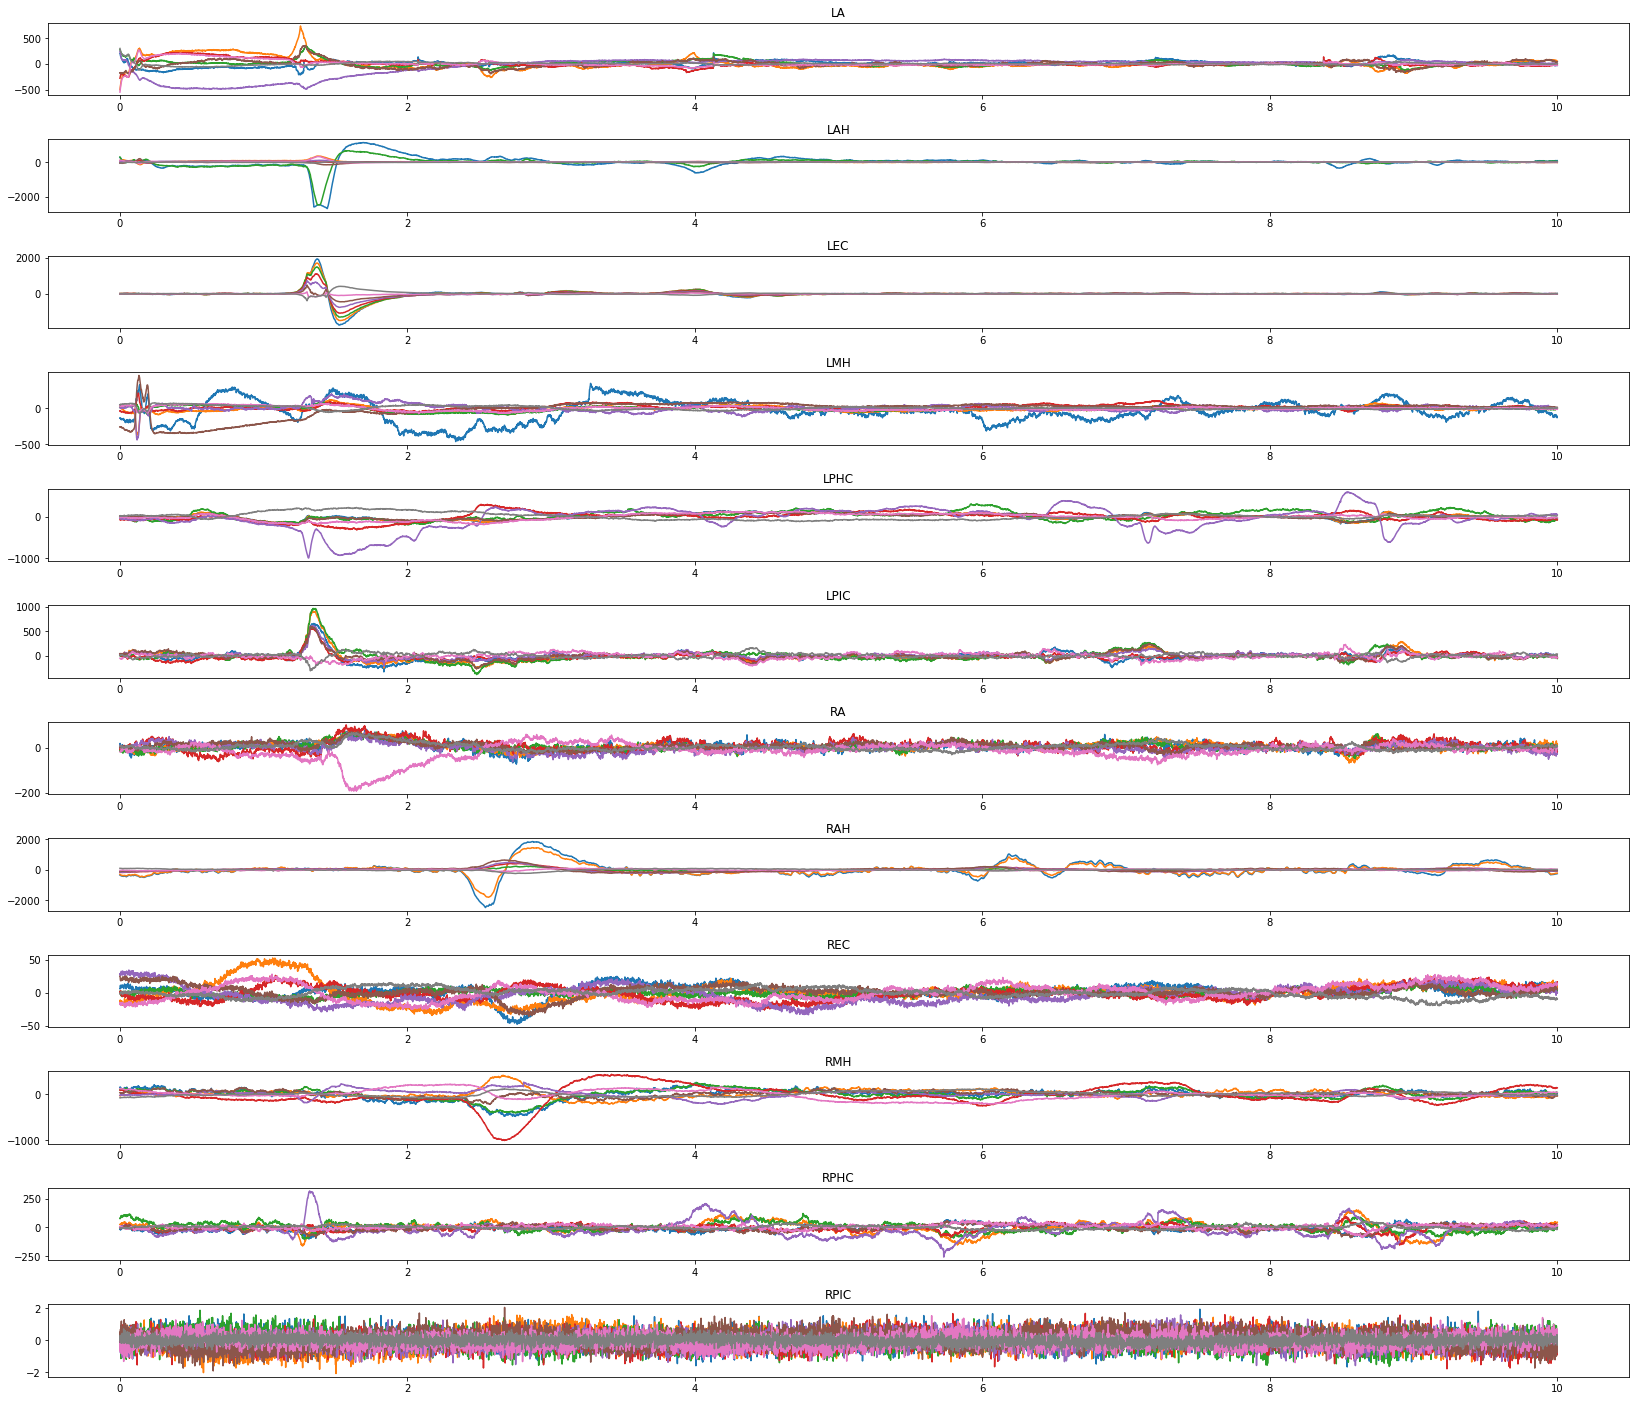

In [95]:
#plot all regions
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(31*60)+11]*len(all_regions)
extra_datapoints = 900

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf+extra_datapoints):(all_onsets[ix]*sf+extra_datapoints)+(10*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

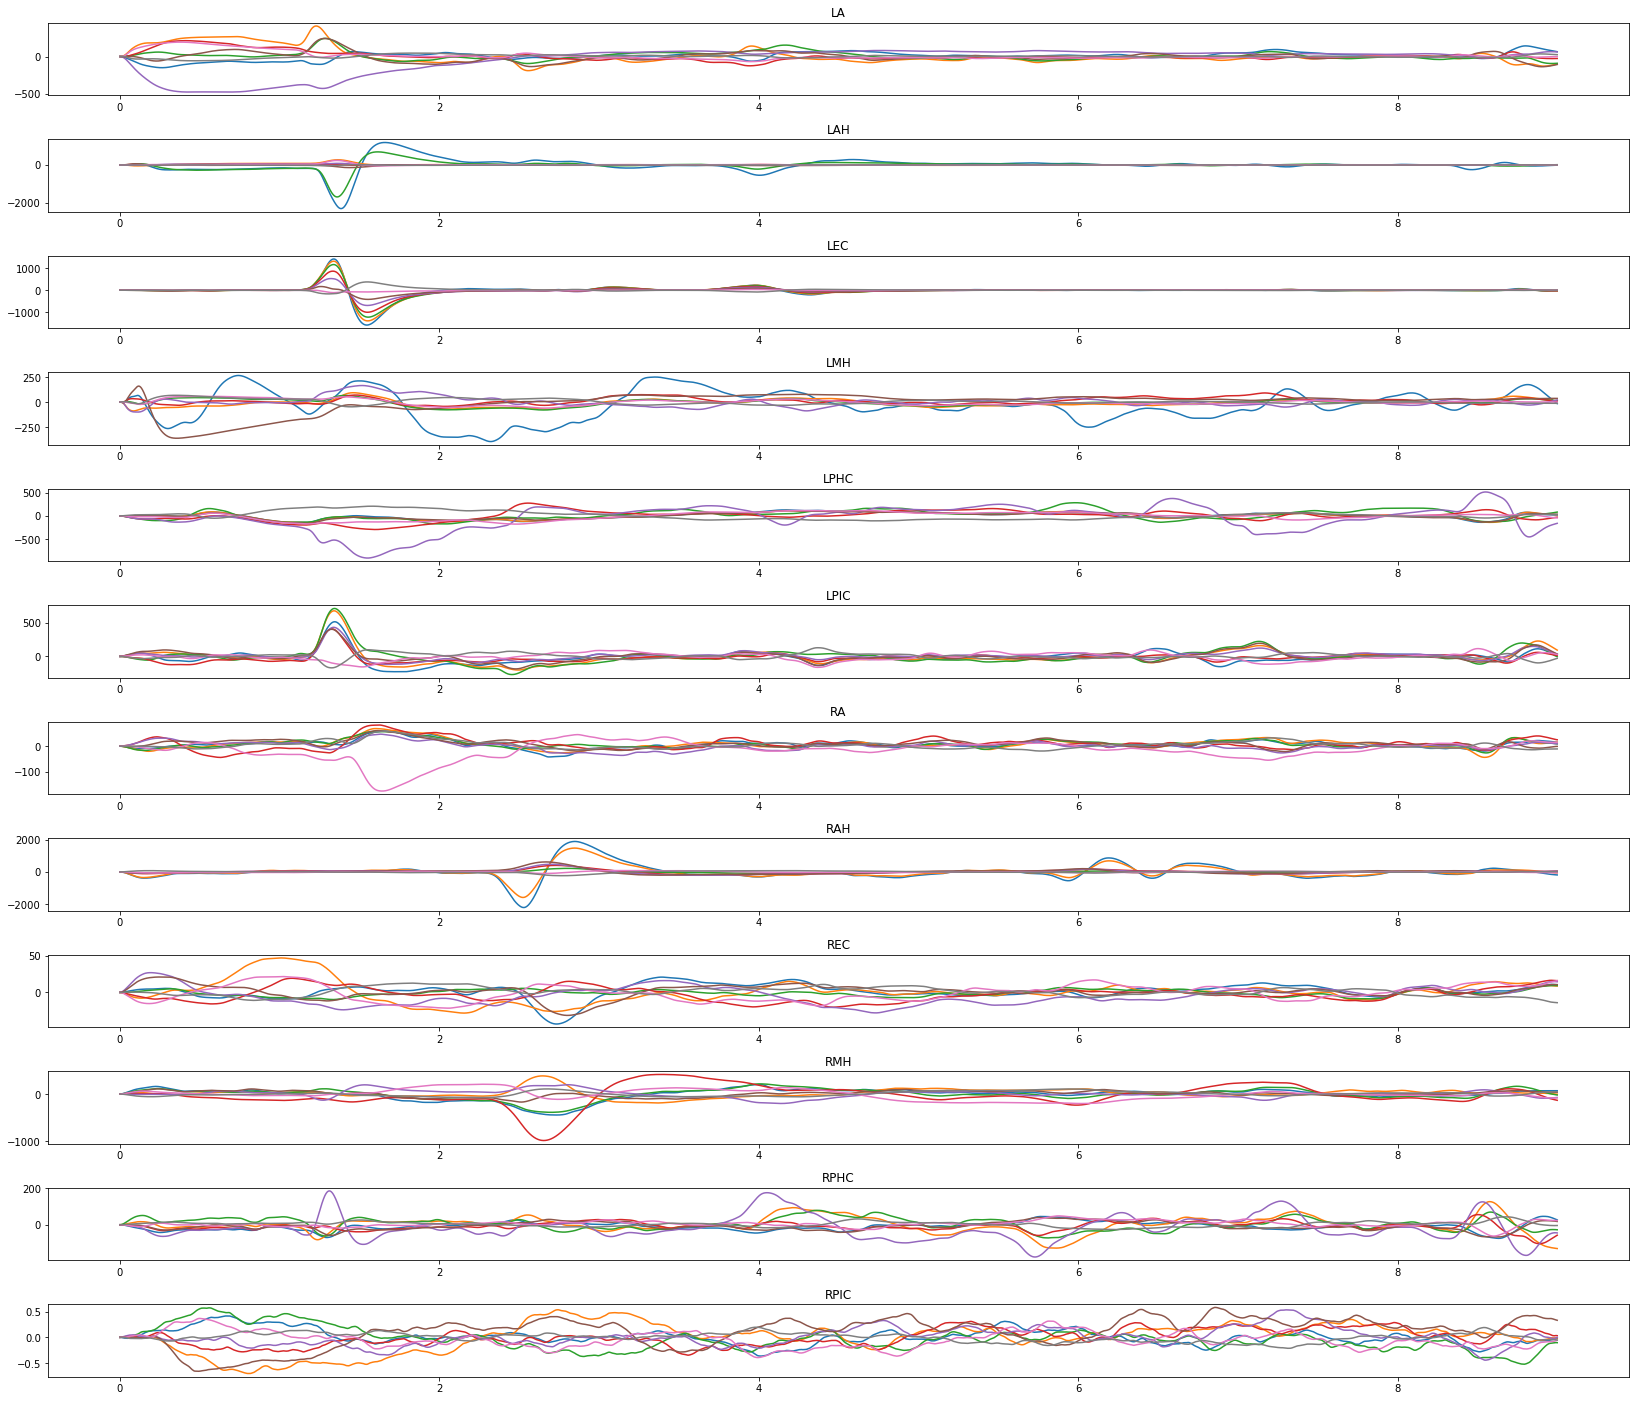

In [99]:
#plot all regions with a low-pass filter
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(30*60)+55]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf+extra_datapoints):(all_onsets[ix]*sf)+(10*sf)]
        data = data[100:]
        filt = butter_lowpass_filter(data, 3, 1000, order=2)
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), filt)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

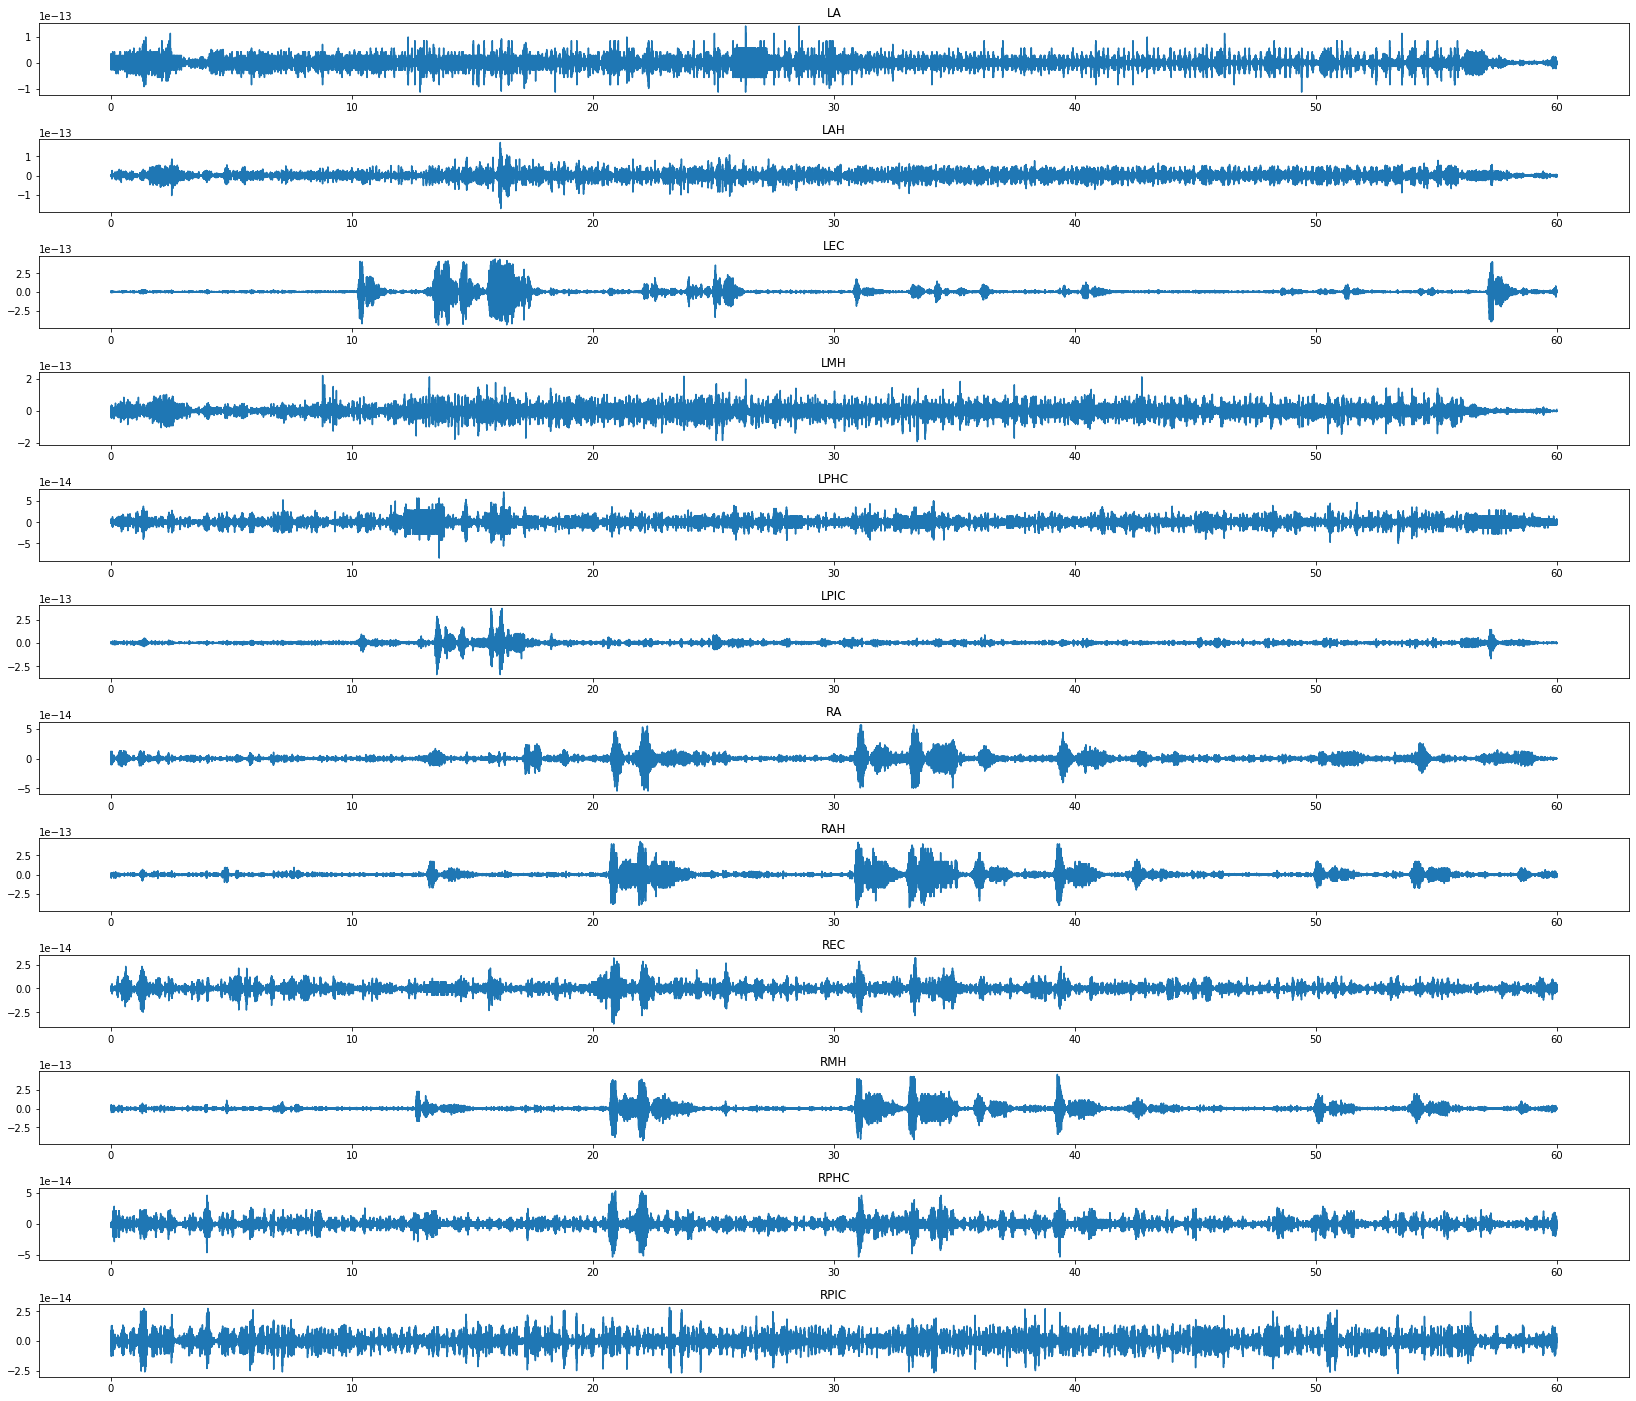

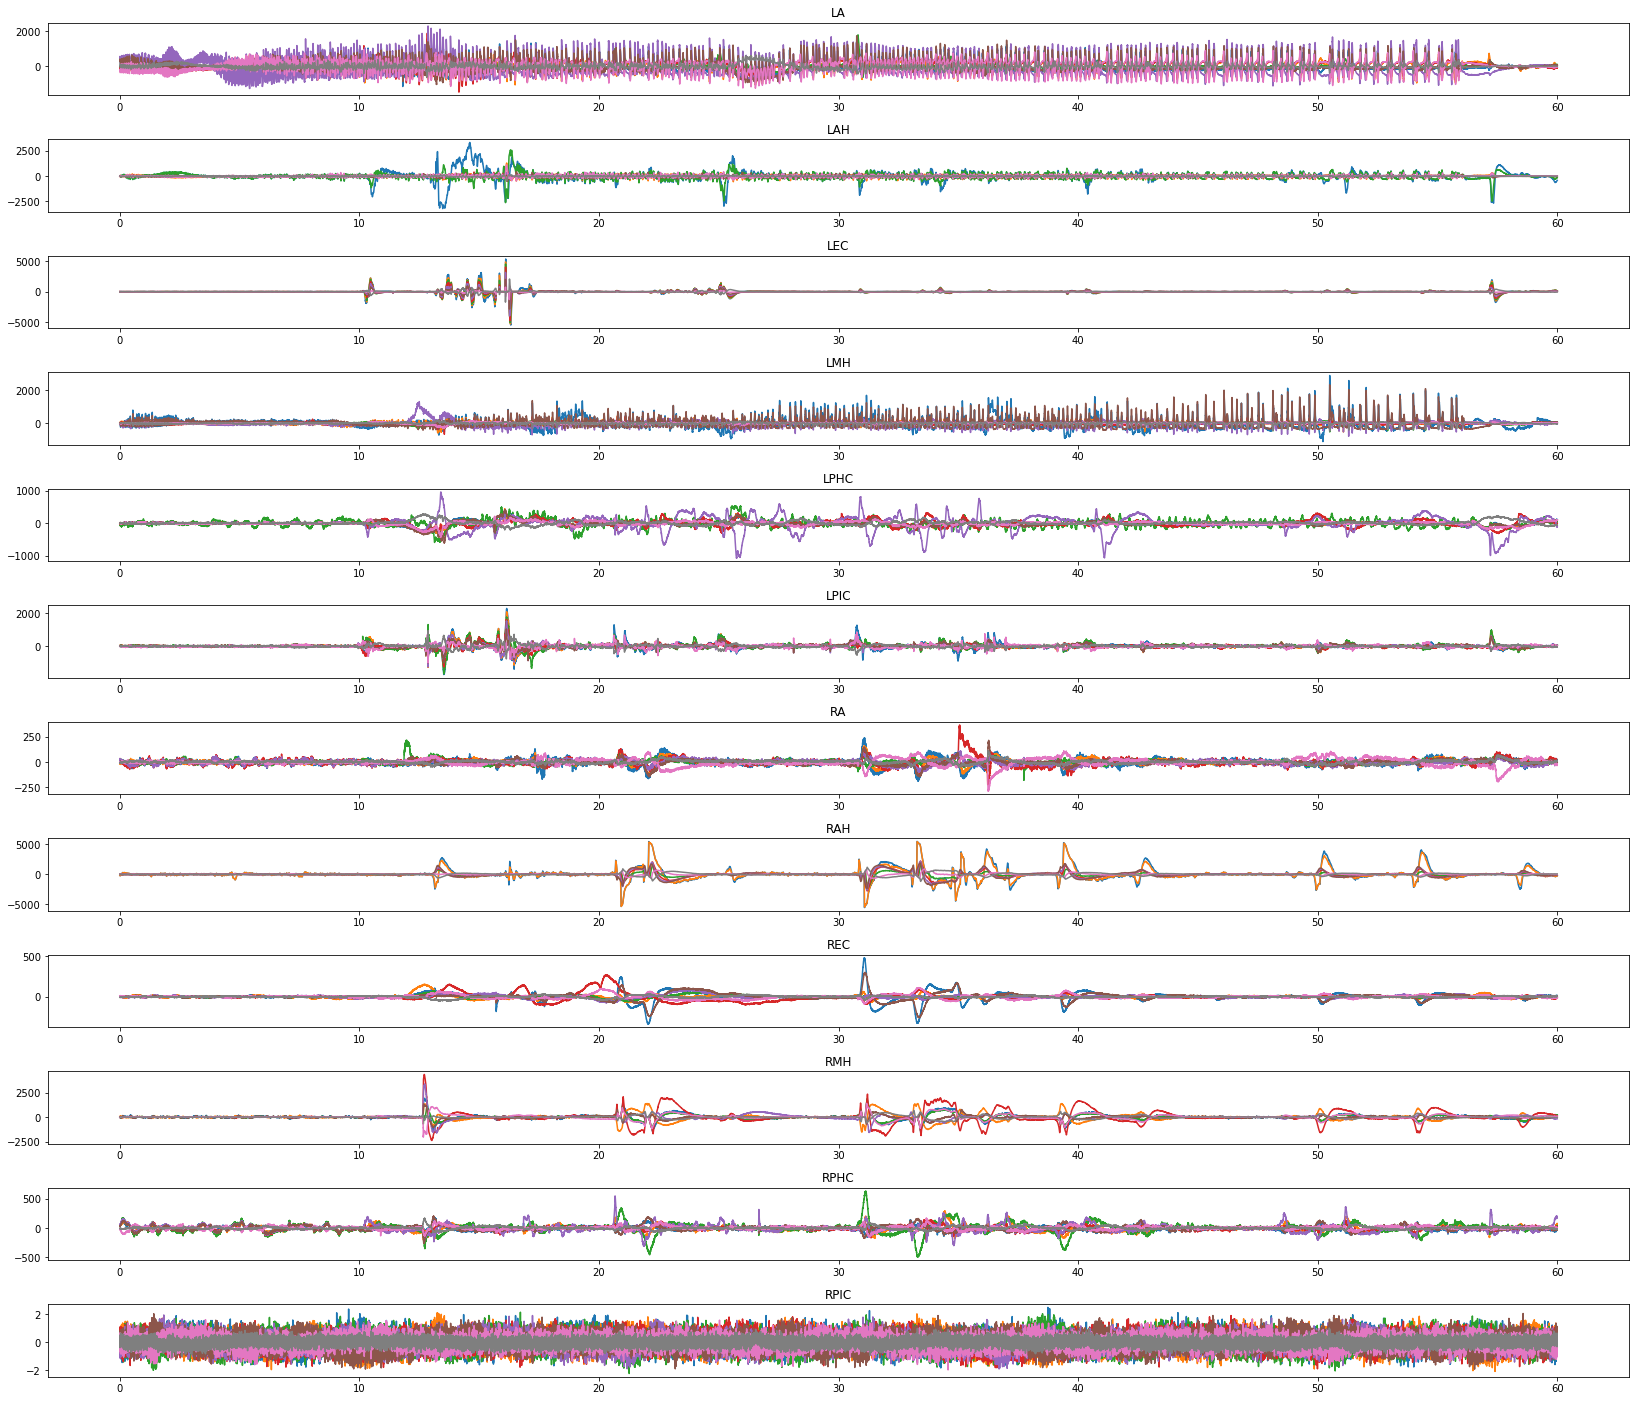

In [100]:
#plot seizure progression
my_dpi = 92
all_regions = list(matfiles_dic.keys())
seizure_onsets = [(30*60)]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    #data = []
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        if i == 0:
            data = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(60*sf)]
        else:
            data_ = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(60*sf)]
            #print(type(data))
            data = np.nanmean([data, data_], axis=0)
        #ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data, color='gray')
    ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi))#, sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    #data = []
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(seizure_onsets[ix]*sf):(seizure_onsets[ix]*sf)+(60*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

In [210]:
#get data from one region only

reg_name = 'LA'
data_in_reg = []
curr_reg = matfiles_dic[reg_name]

for i, ch in enumerate(curr_reg):
    file = readMatfile(os.path.join(reref_path, ch))
    data_in_reg.append(file.reref_data[(all_onsets[0]*sf):(all_onsets[0]*sf)+(10*sf)])
    #ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)


In [211]:
wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=150)

In [212]:
indices = np.argsort(wave_delays)
indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]

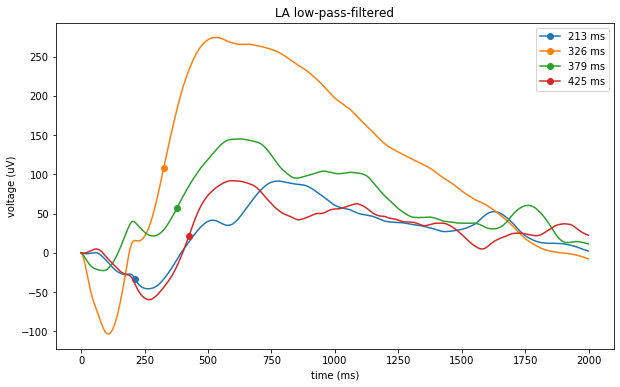

In [213]:
tabcols = list(mcolors.TABLEAU_COLORS.keys())


plt.figure(figsize=(10,6))
for i, ind in enumerate(indices[:]):
    color = tabcols[i+1]
    
    curr_data = data_in_reg[ind]#[:2000]
    res = butter_lowpass_filter(curr_data, 3, 1000, order=2)
    curr_data = res[:2000]
    xdot = int(wave_delays[ind])
    plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
    plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')

plt.xlabel('time (ms)')
plt.ylabel('voltage (uV)')
plt.legend()
plt.title(reg_name+ ' low-pass-filtered')
#plt.savefig(os.path.join(path, f'{reg_name}_sd_delays'))
plt.show()

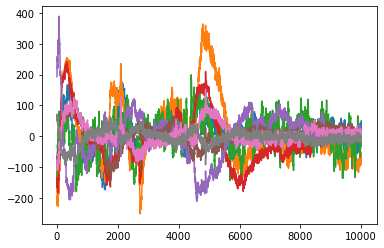

In [173]:
for d in data_in_reg:
    plt.plot(d)
#plt.show()

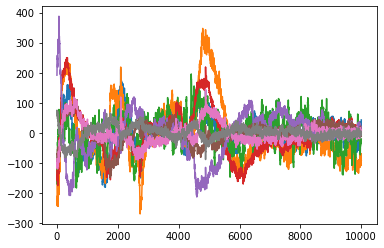

In [175]:
for d in data_in_reg:
    plt.plot(np.subtract(d,d.mean()))
#plt.show()

In [75]:
#curr_reg = matfiles_dic['LAH']
curr_data = data_in_reg[0][:2000]
res = butter_lowpass_filter(curr_data, 3, 1000, order=6)

diff = np.diff(res, n=1)

In [127]:
wave_delays = []

for ix, wire in enumerate(data_in_reg):
    curr_data = wire[150:2000]
    res = butter_lowpass_filter(curr_data, 3, 1000, order=2)
    
    diff = np.diff(res, n=1)
    
    wave_delays.append(abs(diff).argmax() + 150)
    

In [156]:
[d.mean() for d in data_in_reg]

[43.19991700280284,
 9.329493838961131,
 2.6098740223072427,
 -3.8024306913843646,
 3.2249606745198047,
 2.1121525692842824,
 -2.062626409827418,
 -0.5645237111104774]

In [110]:
print(min(np.asarray(data_in_reg).flatten())- max(np.asarray(data_in_reg).flatten()))

-718.9140676371935


In [128]:
wave_delays = np.where(np.asarray(wave_delays)>1000, np.nan, wave_delays)

indices = np.argsort(wave_delays)
indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]

In [129]:
wave_delays

array([213.,  nan, 379.,  nan, 326., 425., 223., 387.])

In [78]:
indices

array([0, 6, 4, 2, 7, 5])

ValueError: cannot convert float NaN to integer

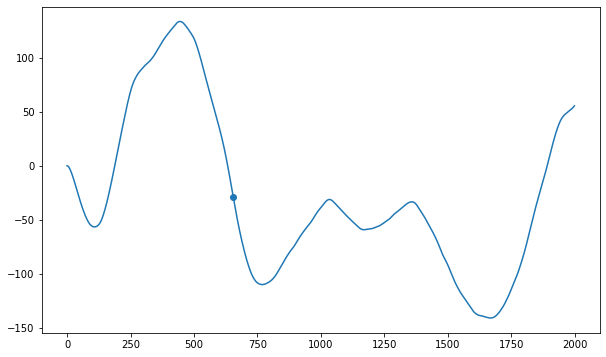

In [178]:
tabcols = list(mcolors.TABLEAU_COLORS.keys())


plt.figure(figsize=(10,6))
for i, ind in enumerate(indices[:]):
    color = tabcols[i+1]
    
    curr_data = data_in_reg[ind]#[:2000]
    res = butter_lowpass_filter(curr_data, 3, 1000, order=2)
    curr_data = res[:2000]
    xdot = int(wave_delays[ind])
    plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
    plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')

plt.xlabel('time (ms)')
plt.ylabel('voltage (uV)')
plt.legend()
plt.title('LAH' + ' low-pass-filtered')
plt.savefig(os.path.join(path, 'LAH_sd_delays'))
plt.show()

In [16]:
onsets

[1811, 1871]

In [169]:
#get all possible pairs


In [170]:
from itertools import combinations

indices = np.arange(0, len(data_in_reg))

combs = list(combinations(indices, 2))

In [171]:
combs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 6),
 (5, 7),
 (6, 7)]

In [218]:
#get cross-correlation pair-wise
cross_corrs = []
lags = []
for i, pair in enumerate(combs):
    #corr = scipy.signal.correlate(data_in_reg[pair[0]], data_in_reg[pair[1]])
    corr = np.correlate(data_in_reg[pair[0]], data_in_reg[pair[1]], 'full')
    corr /= max(abs(corr))
    lag = scipy.signal.correlation_lags(len(data_in_reg[pair[0]]), len(data_in_reg[pair[1]]), mode='full')
    cross_corrs.append(corr)
    lags.append(lag)

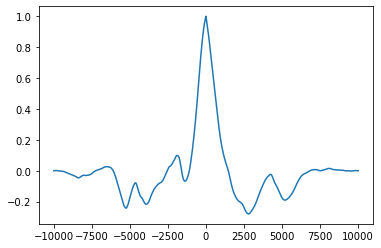

(4, 5) 0


In [175]:
t = -6
dat = abs(cross_corrs[t]).tolist()
plt.plot(lags[t], cross_corrs[t])
plt.show()
print(combs[t], lags[t][dat.index(max(dat))])

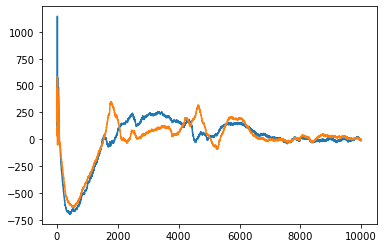

In [176]:
plt.plot(data_in_reg[combs[t][0]])
plt.plot(data_in_reg[combs[t][1]])
plt.show()

[406.14023007   0.62277057 -15.7199858 ] [4.03716892e+01 3.37389906e-02 9.22863988e-01]


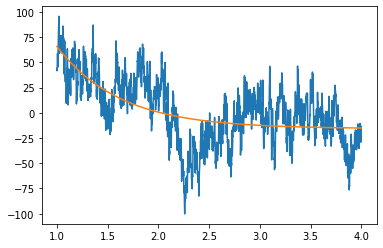

In [236]:
curr_data = data_in_reg[5]
fist_derivative = np.diff(curr_data)
xax = np.linspace(0, len(curr_data)/1000, len(curr_data))

#get log fit

#fit = np.polyfit(np.log(xax[:1*sf]), curr_dat[:1*sf], 1)

#fit, a_= scipy.optimize.curve_fit(lambda t,a,b:  a*np.log(b*t),  xax[:1*sf],curr_data[:1*sf])

#print(fit, a_)

#to_plot = np.log(curr_data[:1*sf])
o = 1000
p = o+((3*sf))
to_plot = curr_data[o:p]
xax = xax[o:p]


nans, x = nan_helper(to_plot)
to_plot[nans] = np.interp(x(nans), x(~nans), to_plot[~nans])

model = lambda x,a,b,c: a * np.exp(-x/b) + c

fit, a_= scipy.optimize.curve_fit(model, xax, to_plot)
#fit = np.polyfit(xax, np.log(to_plot), 1)
print(fit, np.sqrt(np.diag(a_)))
plt.plot(xax, to_plot)
plt.plot(xax, model(xax, *fit))
plt.show()

#scipy.optimize.curve_fit(lambda t,a,b:  a*np.log(b*t),  xax[:1*sf],  curr_data[:1*sf])

In [347]:
for c in mcolors.TABLEAU_COLORS:
    print(c)

tab:blue
tab:orange
tab:green
tab:red
tab:purple
tab:brown
tab:pink
tab:gray
tab:olive
tab:cyan


In [351]:
list(mcolors.TABLEAU_COLORS.keys())

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [521]:
sd_delays = wave_delays[indices[:]]

In [523]:
plt.plot(data_in_reg[indices[1:][3][:2000])
plt.show()

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (1825033604.py, line 1)

In [322]:
sd_delays

array([179., 181., 217., 245.])

In [319]:
np.diff(sd_delays)

array([ 2., 36., 28.])

In [326]:
max(sd_delays) - min(sd_delays)

66.0

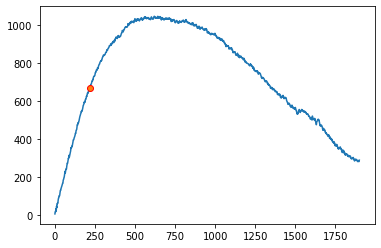

In [291]:
xdot = int(wave_delays[0])

plt.plot(curr_data)
#plt.plot(res)
plt.plot(xdot, curr_data[xdot], marker='o', markeredgecolor="red")
#plt.plot(abs(diff))
plt.show()

In [288]:
wave_delays[0]

217.0

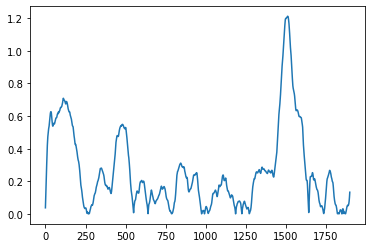

In [272]:
plt.plot(abs(diff))
plt.show()

In [273]:
abs(diff).argmax() + 100

1611

In [321]:
m = np.abs(res).argmax()
actual_min = np.abs(curr_data[m-100:m+100]).argmax()
actual = m-(100-actual_min)

In [318]:
m

486

In [323]:
actual

420

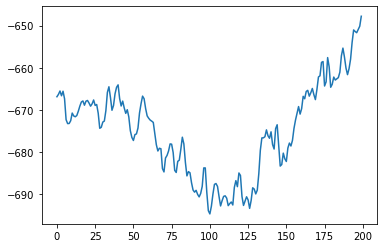

In [322]:
plt.plot(curr_data[actual-100:actual+100])
plt.show()

In [189]:
scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  xax[:1*sf],  curr_data[:1*sf])

/tmp/ipykernel_477284/1038545602.py:1: RuntimeWarning: divide by zero encountered in log
  scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  xax[:1*sf],  curr_data[:1*sf])


(array([1., 1.]),
 array([[inf, inf],
        [inf, inf]]))

In [187]:
scipy.optimize.curve_fit(lambda t,a,b:  a*np.exp(b*t),  xax[:1*sf],  curr_dat[:1*sf])

(array([351.24421982,   1.33369727]),
 array([[ 1.31138245e+02, -4.75205911e-01],
        [-4.75205911e-01,  1.93461719e-03]]))

In [176]:
fit

array([nan, nan])

In [433]:
import datetime as dt



In [448]:
dt.datetime.utcfromtimestamp(1682064664996446/1e6)

datetime.datetime(2023, 4, 21, 8, 11, 4, 996446)

In [449]:
dt.datetime.utcfromtimestamp(1682065865008043/1e6)

datetime.datetime(2023, 4, 21, 8, 31, 5, 8043)

In [450]:
ncs = loadNCS('/media/Seizures/Wenzel/Data/100/2023-04-21_07-31-06/CSC1.ncs')

In [451]:
dt.datetime.utcfromtimestamp(ncs.start/1e6)

datetime.datetime(2023, 4, 21, 7, 31, 5, 995715)

In [452]:
dt.datetime.utcfromtimestamp(ncs.end/1e6)

datetime.datetime(2023, 4, 21, 8, 31, 5, 992418)

In [ ]:
dirlist = [os.path.isdir(os.path.join())]

In [49]:
path = '/media/Seizures/60min_cut/100/2023-04-21_00-40-21/'
path = '/media/Seizures/60min_cut/094/2021-12-11_04-34-59/'
csc_dirs = any([os.path.join(path,i) for i in os.listdir(path) 
                 if (os.path.isdir(os.path.join(path,i)) and 'CSC' in i)])

In [50]:
csc_dirs and (os.path.isdir(os.path.join(path, 'overview')))

True

In [33]:
r = not next(os.scandir(path),None)

In [34]:
r

False

In [50]:
import datetime
import os
from combinato.extract.tools import *
from combinato import NcsFile
from combinato.basics.filters import *

%cd /media/Projects/Adrian/seizureProcessing/

from seizureProcessing.utils.loadNCS import *
from seizureProcessing.prepare_directory.unren_batch import *

/media/Projects/Adrian/seizureProcessing


In [47]:
path = '/media/Seizures/8min_cut/099/2023-03-03_06-03-00/'
fnmae = 'CSC97.ncs'

file = loadNCS(os.path.join(path, fnmae))

In [49]:
file.header

["b'######## Neuralynx Data File Header",
 '-FileType NCS',
 '-FileVersion 3.4',
 '-FileUUID 2c523102-f58c-4de8-b678-97cc4fcb7dc6',
 '-SessionUUID cf317ccb-e872-44cf-b992-b40756321b1a',
 '-ProbeName ',
 '-OriginalFileName "D:\\\\2023-03-02_14-38-28\\\\RSP1+_0004.ncs"',
 '-TimeCreated 2023/03/03 05:35:13',
 '-TimeClosed 2023/03/03 09:38:07',
 '',
 '-RecordSize 1044',
 '-ApplicationName Pegasus "2.1.3 "',
 '-AcquisitionSystem Micromed ATLAS',
 '-ReferenceChannel "Source 02 Reference 3"',
 '-SamplingFrequency 2048',
 '-ADMaxValue 32767',
 '-ADBitVolts 0.000000048828125000000002',
 '-AcqEntName RSP1+',
 '-NumADChannels 1',
 '-ADChannel 30',
 '-InputRange 1600',
 '-InputInverted True',
 '',
 '-DSPLowCutFilterEnabled True',
 '-DspLowCutFrequency 0.1',
 '-DspLowCutNumTaps 0',
 '-DspLowCutFilterType DCO',
 '-DSPHighCutFilterEnabled True',
 '-DspHighCutFrequency 512',
 '-DspHighCutNumTaps 256',
 '-DspHighCutFilterType FIR',
 '-DspDelayCompensation Enabled',
 '## Time Opened (m/d/y): 3/3/2023  (

In [35]:
file.ncs_file.timestep

3.0517578125e-05

In [36]:
file.ncs_file.filename

'/media/Seizures/8min_cut/099/2023-03-03_06-03-00/CSC95.ncs'

In [37]:
start = 0
stop = file.ncs_file.num_recs
blocksize = 10000

if stop % blocksize > blocksize/2:
    laststart = stop-blocksize
else:
    laststart = stop
    
starts = list(range(start, laststart, blocksize))
stops = starts[1:] + [stop]
name = os.path.splitext(os.path.basename(file.ncs_file.filename))[0]

destination = ''
reference = None

In [38]:
name

'CSC95'

In [39]:
stop

30720

In [40]:
jobs = []
for i in range(len(starts)):
    jdict = {'name': name,
             'filename': file.ncs_file.filename,
             'start': starts[i],
             'stop': stops[i],
             'count': i,
             'destination': destination,
             'reference': reference}
    jobs.append(jdict)

In [41]:
jobs

[{'name': 'CSC95',
  'filename': '/media/Seizures/8min_cut/099/2023-03-03_06-03-00/CSC95.ncs',
  'start': 0,
  'stop': 10000,
  'count': 0,
  'destination': '',
  'reference': None},
 {'name': 'CSC95',
  'filename': '/media/Seizures/8min_cut/099/2023-03-03_06-03-00/CSC95.ncs',
  'start': 10000,
  'stop': 20000,
  'count': 1,
  'destination': '',
  'reference': None},
 {'name': 'CSC95',
  'filename': '/media/Seizures/8min_cut/099/2023-03-03_06-03-00/CSC95.ncs',
  'start': 20000,
  'stop': 30000,
  'count': 2,
  'destination': '',
  'reference': None},
 {'name': 'CSC95',
  'filename': '/media/Seizures/8min_cut/099/2023-03-03_06-03-00/CSC95.ncs',
  'start': 30000,
  'stop': 30720,
  'count': 3,
  'destination': '',
  'reference': None}]

In [42]:
file.ncs_file.timestep

3.0517578125e-05

In [43]:
res = DefaultFilter(file.ncs_file.timestep)

TEST: timestep: 3.0517578125e-05, (0.018310546875, 0.06103515625)


In [59]:
path = '/media/Seizures/8min_cut/099/2023-03-03_07-00-00'

In [60]:
unren_batch(path)

CSC1.ncs --> LA1.ncs
CSC2.ncs --> LA2.ncs
CSC3.ncs --> LA3.ncs
CSC4.ncs --> LA4.ncs
CSC5.ncs --> LA5.ncs
CSC6.ncs --> LA6.ncs
CSC7.ncs --> LA7.ncs
CSC8.ncs --> LA8.ncs
CSC9.ncs --> LMH1.ncs
CSC10.ncs --> LMH2.ncs
CSC11.ncs --> LMH3.ncs
CSC12.ncs --> LMH4.ncs
CSC13.ncs --> LMH5.ncs
CSC14.ncs --> LMH6.ncs
CSC15.ncs --> LMH7.ncs
CSC16.ncs --> LMH8.ncs
CSC17.ncs --> LPHC1.ncs
CSC18.ncs --> LPHC2.ncs
CSC19.ncs --> LPHC3.ncs
CSC20.ncs --> LPHC4.ncs
CSC21.ncs --> LPHC5.ncs
CSC22.ncs --> LPHC6.ncs
CSC23.ncs --> LPHC7.ncs
CSC24.ncs --> LPHC8.ncs
CSC25.ncs --> RA1.ncs
CSC26.ncs --> RA2.ncs
CSC27.ncs --> RA3.ncs
CSC28.ncs --> RA4.ncs
CSC29.ncs --> RA5.ncs
CSC30.ncs --> RA6.ncs
CSC31.ncs --> RA7.ncs
CSC32.ncs --> RA8.ncs
CSC33.ncs --> RACC1.ncs
CSC34.ncs --> RACC2.ncs
CSC35.ncs --> RACC3.ncs
CSC36.ncs --> RACC4.ncs
CSC37.ncs --> RACC5.ncs
CSC38.ncs --> RACC6.ncs
CSC39.ncs --> RACC7.ncs
CSC40.ncs --> RACC8.ncs
CSC41.ncs --> RAH1.ncs
CSC42.ncs --> RAH2.ncs
CSC43.ncs --> RAH3.ncs
CSC44.ncs --> RAH4.n

In [62]:
mins = 4
period = 70

if period >= 60:
    res = 

10

In [77]:
time_start_extract = datetime.datetime.now()

In [78]:
time_end_extract = datetime.datetime.now()

In [79]:
period_extract = time_end_extract - time_start_extract 

In [85]:
prep_min = period_extract.seconds//60

In [86]:
prep_min//60

0

In [89]:
ps = period_extract.seconds

In [92]:
if ps >=60:
    ps = ps%60
    prep_min += 1
ps

35

In [82]:
period_extract.total_seconds()

155.134714

In [8]:
file = loadNCS('/media/adrian/TOSHIBA EXT/2023-11-09_18-35-45/AHL1_0002.ncs')

In [12]:
file.header

["b'######## Neuralynx Data File Header",
 '-FileType NCS',
 '-FileVersion 3.4',
 '-FileUUID 0b6a3abe-10b9-415c-b0e3-7cee946c52d5',
 '-SessionUUID b4875721-3cf7-4f00-b5f8-958ec8d43a3e',
 '-ProbeName ',
 '-OriginalFileName "D:\\\\2023-11-09_18-35-45\\\\AHL1_0002.ncs"',
 '-TimeCreated 2023/11/09 23:35:19',
 '-TimeClosed 2023/11/10 03:40:21',
 '',
 '-RecordSize 1044',
 '-ApplicationName Pegasus "2.1.3 "',
 '-AcquisitionSystem Micromed ATLAS',
 '-ReferenceChannel "Source 01 Subject Ground"',
 '-SamplingFrequency 2048',
 '-ADMaxValue 32767',
 '-ADBitVolts 0.000000048828125000000002',
 '-AcqEntName AHL1',
 '-NumADChannels 1',
 '-ADChannel 88',
 '-InputRange 1600',
 '-InputInverted True',
 '',
 '-DSPLowCutFilterEnabled True',
 '-DspLowCutFrequency 0.1',
 '-DspLowCutNumTaps 0',
 '-DspLowCutFilterType DCO',
 '-DSPHighCutFilterEnabled True',
 '-DspHighCutFrequency 512',
 '-DspHighCutNumTaps 256',
 '-DspHighCutFilterType FIR',
 '-DspDelayCompensation Enabled',
 '-DspFilterDelay_\\xb5s 3891',
 "'"